# Implementation of MLP model for Grokking



## Data Generation

The input expected is a $2p$ dimensional vector of one hot encoded representation of the inputs in $\mathbb{Z}_p$. Also, the parameter $\alpha$ which determines how the data is split into train/test (i.e. $\alpha$ % of data is used for training).

In [1]:
from sklearn.model_selection import train_test_split
import torch
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def is_prime(num: int) -> bool:
    """
    returns True if a number is prime and False otherwise
    """
    # Input validation
    assert isinstance(num, int), 'Expected an integer data type'
    t = 1
    if num <= 1 :
        return False
    else:
        for m in range (2, int(num**0.5)+1) :
            t = (num % m)
            if t == 0:
                return False
    return True

def division_mod_p(operand1: int, operand2: int, p: int) -> int:
    """
    returns (operand1 / operand2) % p
    """
    # Input validation
    assert isinstance(operand1, int), 'Expected an integer data type'
    assert isinstance(operand2, int), 'Expected an integer data type'
    assert isinstance(p, int), 'Expected an integer data type'
    assert is_prime(p), 'Expected a prime number'
    assert (operand2 % p != 0), 'Division by zero'

    # Algorithm
    check = operand1
    while check % operand2 != 0:
        check += p
    return (check//operand2) % p

def exponent_mod_p(base: int, exponent: int, p: int) -> int:
    """
    returns (base ** exponent) % p
    """
    # Input validation
    assert isinstance(base, int), 'Expected an integer data type'
    assert isinstance(exponent, int), 'Expected an integer data type'
    assert isinstance(p, int), 'Expected an integer data type'
    if exponent < 0:
        assert (base % p != 0), 'Division by zero'

    # Algorithm
    if exponent < 0:
        return division_mod_p(1, base ** (-exponent), p)
    return (base ** exponent) % p

OPERATIONS = {
    "x+y"   : lambda x, y, p: (x + y)%p,
    "x-y"   : lambda x, y, p: (x - y)%p,
    "x*y"   : lambda x, y, p: (x * y)%p,
    "x/y"   : lambda x, y, p: division_mod_p(x, y, p),
    "x^y"   : lambda x, y, p: exponent_mod_p(x, y, p), # Note! 0^0 = 1
    "2x-y"  : lambda x, y, p: (2*x - y)%p,
"2**x+y**2" : lambda x, y, p: (2**x + y**2)%p,
 "x^2+y^2"  : lambda x, y, p: (x**2 + y**2)%p,
"x^3+xy^2+y": lambda x, y, p: (x**3 + x*(y**2) + y)%p,
    "const" : lambda x, y, p: 1,
    "rand"  : lambda x, y, p: random.randint(0, p-1),
  "x^y+y^x" : lambda x, y, p: (x**y + y**x)%p,
    "chess" : lambda x, y, p: (x+y)%2,
    "diag"  : lambda x, y, p: int(x==y),
}

LATEX = {
    "x+y"   : "$(x+y) \\mathbb{Z}_p$",
    "x-y"   : "$(x-y) \\mathbb{Z}_p$",
    "x*y"   : "$(xy) \\mathbb{Z}_p$",
    "x/y"   : "$(\\frac{x}{y}) \\mathbb{Z}_p$",
    "x^y"   : "$(x^y) \\mathbb{Z}_p$", # Note! 0^0 = 1
    "2x-y"  : "$(2x-y) \\mathbb{Z}_p$",
"2**x+y**2" : "$(2^x+y^2) \\mathbb{Z}_p$",
"x^2+y^2"   : "$(x^2+y^2) \\mathbb{Z}_p$",
"x^3+xy^2+y": "$(x^3+xy^2+y) \\mathbb{Z}_p$",
    "const" : "$constant \\mathbb{Z}_p$",
    "rand"  : "$rand \\mathbb{Z}_p$",
  "x^y+y^x" : "$(x^y+y^x) \\mathbb{Z}_p$",
    "chess" : "$chess \\mathbb{Z}_p$",
    "diag"  : "$diag \\mathbb{Z}_p$",
}

omit = {"x/y", "2**x+1/y"}

tups = []           # Get the inputs
outs = []           # Get the outputs
train_inputs = []   # Get the inputs used in training
test_inputs = []    # Get the inputs used in testing
train_outputs = []  # Get the outputs used in training
test_outputs = []   # Get the outputs used in testing

def one_hot(input: int, p: int) -> list: # torch.Tensor:
    """
    Returns a one hot coded representation of input with respect to p.
    """

    # Input validation
    assert isinstance(input, int), 'Expected an integer data type'
    assert isinstance(p, int), 'Expected an integer data type'
    assert input < p, 'Expected inputs from Zp'
    assert input >= 0, 'Expected inputs from Zp'

    out = [0 for _ in range(p)]
    out[input] = 1
    return out

def grok_data(operation: str, p: int, alpha: float) -> tuple:
    """
    Generates data for model

    Parameters:
    operation        : A string for the type of modular operation
    p                : The prime number
    alpha            : Frcation by which to split the data into training and test
    """

    global tups
    global outs
    global train_inputs
    global test_inputs
    global train_outputs
    global test_outputs

    assert isinstance(alpha, float), 'Expected a float data type'
    assert (alpha < 1 and alpha > 0), 'Alpha should be between 0 and 1'

    labels = []

    x = [i for i in range(p)]
    if operation not in omit:
        y = [i for i in range(p)]
    else:
        y = [i for i in range(1, p)]

    tups.clear()
    outs.clear()
    for op1 in x:
        for op2 in y:
            tups.append((op1, op2))
            labels.append(OPERATIONS[operation](op1, op2, p))
            outs.append(OPERATIONS[operation](op1, op2, p))

    train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(tups, labels, random_state=42,
                                                      test_size=1-alpha, shuffle=True)

    X_train = [one_hot(op1, p)+one_hot(op2, p) for (op1, op2) in train_inputs]
    X_test = [one_hot(op1, p)+one_hot(op2, p) for (op1, op2) in test_inputs]
    y_train = [one_hot(y, p) for y in train_outputs]
    y_test = [one_hot(y, p) for y in test_outputs]

    return (X_train, y_train), (X_test, y_test)

## MLP

Here I implemented the MLP taking a hint from what was described in [Andrey Gromov's paper](https://arxiv.org/pdf/2301.02679), but the output of the final layer is projected on the $\mathbb{R}^p$ unit ball using the $L_2$ norm. I observed this to have the best performance so far. (Outperformed using softmax or $L_1$ projection). The intuition came from the fact that one hot encoding transforms the inputs to points on the unit ball in $\mathbb{R}^p$ and so, I believed limiting the codomain of the neural network would help it learn better. I used the cross entropy loss function and ReLu activation function.

Unlike the suggestion in the paper by Andrey, I did not need to consider the starting condition of the parameters. Also, using MSE loss gave bad performance. I also observed that having the hidden dimension to be about $\approx < 5prime$ has the best performance. I do not know why exactly but I guess that having more parameters than necessary in a wide network slows down learning as it will have to send some weights to zero. I feel drop out as a regularisation method could help solve this issue though I have not tested this yet.

***Innovation (new original idea)***: The projection on the $L_2$ unit ball.

***Further Analysis***: Could this be a very good type of activation function that gives more stability to the neural network?

In [6]:
import torch
import torch.nn as nn
import numpy as np

class quadratic_activation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * x

class unit_ball_proj_l2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x/torch.linalg.vector_norm(x)

class stab_max(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.log(nn.ReLU()(x) + 1.0)-torch.log(nn.ReLU()(-x) + 1.0)

class MLP_Grok(nn.Module):
    def __init__(self, prime, hidden_dim):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)
        self.contract = unit_ball_proj_l2()

    def forward(self, x):
        return self.contract(self.output(self.activation(self.input(x))))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

class MLP_Grok1(nn.Module): # Model without post-logit activation
    def __init__(self, prime, hidden_dim):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok1, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)

    def forward(self, x):
        return self.output(self.activation(self.input(x)))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

class MLP_Grok3(nn.Module): # Model with drop out
    def __init__(self, prime, hidden_dim, drop_out):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok3, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)
        self.reg = nn.Dropout(drop_out)

    def forward(self, x):
        return self.output(self.reg(self.activation(self.input(x))))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

class MLP_Grok4(nn.Module): # Model prieto
    def __init__(self, prime, hidden_dim):
        # Note! prime is not input size, but input size is 2 * prime.
        # This is because of two inputs for binary operation

        super(MLP_Grok4, self).__init__()
        self.prime = prime
        self.input_dim = 2*prime
        self.hidden_dim = hidden_dim
        self.input = nn.Linear(self.input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, prime)
        self.out = stab_max()

    def forward(self, x):
        return self.out(self.output(self.activation(self.input(x))))

    def predict(self, x):
        # Expects a tuple e.g (91, 37).
        # One hot encoding done within the method
        self.eval()
        x   = torch.tensor(one_hot(x[0], self.prime)+one_hot(x[1], self.prime), dtype=torch.float32)
        out = self.input(x)
        out = self.activation(out)
        out = self.output(out)
        out = torch.argmax(out)
        return out.item()

## Data collection during training

Here, I introduce a function, ```grokking_epoch```, to measure the epoch grokking occurs given two thresholds $\in [0; 1]$. For example, with a ```threshold1``` of $0.9$, and a ```threshold2``` of $0.8$ the gap between the train and test accuracies should have been up to $0.9$ at some epoch, and the test accuracy must have reached $0.8$ within the allocated number of epochs. It returns ```None``` otherwise.

I also introduce a function, ```rate_of_change```, to measure the rate of change of the accuracies and losses per epoch.

I used stochastic gradient descent.


In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim

model = None

def experiment(prime: int, operation: str, # positional arguments
               hidden_dim: int = 500,
               epochs: int = 1_000,
               alpha: float = 0.5,
               criterion = nn.CrossEntropyLoss(reduction='sum'),
               weight_decay: float = 0.0,
               seed = 42):
    '''
    Returns train_acc, test_acc, train_loss, test_loss, weight_norm
    '''

    global model
    global device

    torch.manual_seed(seed)
    if not model: # Else to continue previous training session if necessary
        model = MLP_Grok(prime, hidden_dim)
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)

    # Make sure model is on device
    model.to(device)

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    weight_norm = []

    train_set, test_set = grok_data(operation, prime, alpha)
    X_train, y_train = train_set
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)

    X_test, y_test = test_set
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device, requires_grad=False)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device, requires_grad=False)

    for epoch in tqdm(range(epochs)):
        # Train mode
        model.train()

        outputs = model(X_train)
        acc = (torch.argmax(outputs, dim=1) == torch.argmax(y_train, dim=1)).float().mean()
        loss = criterion(outputs, y_train)

        # Backtrack and calculate gradients
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        # Record loss and accuracies
        train_loss.append(loss.cpu().item())
        train_acc.append(acc.cpu().item())

        model.eval()
        with torch.no_grad():

            outputs = model(X_test)
            acc = (torch.argmax(outputs, dim=1) == torch.argmax(y_test, dim=1)).float().mean()
            loss = criterion(outputs, y_test)

            test_loss.append(loss.cpu().item())
            test_acc.append(acc.cpu().item())

            W_norm = 0.0

            for name, W in model.named_parameters():
                if 'weight' in name:
                    W_norm += W.norm(2)
            weight_norm.append(W_norm.cpu().item())

        if test_acc[-1] == 1.0:
            print("=====================================")
            print('Early stopping: Test accuracy is 100%')
            print("=====================================")
            break

        if epoch % 1000 == 0:
            print("Test accuracy  -> ", test_acc[-1])
            print("Train accuracy -> ", train_acc[-1])

    return train_acc, test_acc, train_loss, test_loss, weight_norm

def grokking_epoch(threshold1, threshold2, train_acc, test_acc):
    # If the required gap between train/test accuracy is not reached
    # Pick the epoch with largest available gap and print "threshold1 not reached"
    # If required test accuracy is not reached
    # Pick the epoch with the highest available accuracy and print "threshold2 not reached"

    start_epoch = 0
    end_epoch = 0
    for epoch in range(len(train_acc)):
        if (train_acc[epoch] - test_acc[epoch]) >= threshold1:
            start_epoch = epoch+1
        if test_acc[epoch] >= threshold2:
            end_epoch = epoch+1

    if start_epoch == 0:
        a = np.array(train_acc)
        b = np.array(test_acc)
        c = a-b
        temp1  = np.argmax(c)+1
        if end_epoch != 0:
            start_epoch = temp1
            print('======================')
            print("threshold1 not reached")
            print('======================')
            print()
            print('=======================================================================================')
            print(f"Largest gap between accuracies of train and test is {c[temp1-1]} at epoch {temp1}")
            print('=======================================================================================')
            # return start_epoch, end_epoch

    if end_epoch == 0:# test_acc[end_epoch-1] <= threshold2:
        b = np.array(test_acc)
        temp2 = np.argmax(b)+1
        if start_epoch != 0:
            end_epoch = temp2
            print('======================')
            print("threshold2 not reached")
            print('======================')
            print()
            print('===============================================================')
            print(f"Highest test accuracy is {b[temp2-1]} at epoch {temp2}")
            print('===============================================================')
            # return start_epoch, end_epoch

    if start_epoch == 0 and end_epoch == 0:
        print('=====================================')
        print("threshold1 and threshold2 not reached")
        print('=====================================')
        print()
        print('==================================================================================')
        print(f"Largest gap between accuracies of train and test is {c[temp1-1]} at epoch {temp1}")
        print('==================================================================================')
        print()
        print('=========================================================')
        print(f"Highest test accuracy is {b[temp2-1]} at epoch {temp2}")
        print('=========================================================')
        return temp1, temp2

    return start_epoch, end_epoch

def rate_of_change(data):

    global model
    global tups
    global train_inputs
    global test_inputs

    l = len(data)
    out = []
    for i in range(l-1):
        out.append(data[i+1]-data[i])
    return out

def plots(train_acc,
          test_acc,
          train_loss,
          test_loss,
          weight_norm,
          prime,
          operation,
          alpha,
          threshold1=0.9, threshold2=0.85):

    train_acc_rate  = rate_of_change(train_acc)
    test_acc_rate   = rate_of_change(test_acc)
    train_loss_rate = rate_of_change(train_loss)
    test_loss_rate  = rate_of_change(test_loss)

    grok_epoch = grokking_epoch(threshold1, threshold2, train_acc, test_acc)
    start_epoch = 0
    end_epoch = len(test_acc)

    if grok_epoch:
        start_epoch = grok_epoch[0]
        end_epoch = grok_epoch[1]
    else:
        print('=====================================================================================================')
        print(f'Threshold not achieved, using default start and end epoch of {start_epoch} and {end_epoch}, respectively')
        print('=====================================================================================================')

    print()
    print('=================================')
    print(int(alpha*100), '% of data for training')
    print('=================================')
    print()
    # Plots from MatPlotlib
    xs = [i+1 for i in range(len(train_acc))]
    plt.plot(xs, weight_norm, label = 'weight_norm')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Norm')
    plt.title(f'$L_2$ Norm of the weight matrix of the neural network $p=${prime}: ' + LATEX[operation])
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_loss.png')
    plt.show()

    plt.plot(xs, train_acc, label = 'Train')
    plt.plot(xs, test_acc, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = test_acc[-1], color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Comparison of Train and Validation for $p=${prime}: ' + LATEX[operation])
    plt.legend(loc = 4)
    # plt.savefig('/content/grokking_accuracy.png')
    plt.show()

    plt.plot(xs, train_loss, label = 'Train')
    plt.plot(xs, test_loss, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = train_loss[-1], color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Comparison of Train and Validation for $p=${prime}: ' + LATEX[operation])
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_loss.png')
    plt.show()

    xs = [i+1 for i in range(len(train_acc_rate))]
    plt.plot(xs, train_acc_rate, label = 'Train')
    plt.plot(xs, test_acc_rate, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = 0, color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('$\Delta$ Accuracy')
    plt.title(f'Rate of change per epoch of accuracy for $p=${prime}: ' + LATEX[operation])
    # plt.xscale("log", base=10)
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_accuracy.png')
    plt.show()

    plt.plot(xs, train_loss_rate, label = 'Train')
    plt.plot(xs, test_loss_rate, label = 'Validation')
    plt.axvline(x = start_epoch, color = 'g', label = 'start_epoch')
    plt.axvline(x = end_epoch, color = 'r', label = 'end_epoch')
    plt.axhline(y = 0, color = 'c', linestyle = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel('$\Delta$ Loss')
    plt.title(f'Rate of change per epoch of loss for $p=${prime}: ' + LATEX[operation])
    # plt.xscale("log", base=10)
    plt.legend(loc = 1)
    # plt.savefig('/content/grokking_loss.png')
    plt.show()

def run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = 500, weight_decay = 0.0):

    train_acc, test_acc, train_loss, test_loss, weight_norm = experiment(prime, operation, epochs = epochs, alpha = alpha, hidden_dim = hidden_dim, weight_decay = weight_decay)
    plots(train_acc, test_acc, train_loss, test_loss, weight_norm, prime, operation, alpha, threshold1, threshold2)

def extract_hard_to_learn(operation, prime):

    # global model
    global test_inputs
    print("Assuming 100% train accuracy for ", f"{operation} mod{prime}")
    out = []
    for i in range(len(test_inputs)):
        tup = test_inputs[i]
        model.to("cpu")
        if model.predict(tup) != test_outputs[i]:
            out.append(tup)
    return out

## Metric to measure the difficulty of the model to learn the operation

To do this, I considered the $KL$ divergence of the full set (train + test) distribution (per row and then per column) from the train set distribution. I sum these values and investigate the correlation between these values and grokking epoch. In essesnce, if $P_R$ represents the true distribution of values on a row, $R$, and $Q_R$ represents the distribution of the training data ($C$ is column anagloguosly), then my metric is,

$$\sum _{R \in rows} D_{KL}(P_R\|Q_R) + \sum _{C \in columns} D_{KL}(P_C\|Q_C)$$


A second attempt was to use a cosine similarity informed metric. I take the average, then inverse and subtract one so that its directly to proportional to learning difficulty. Finally, I divide by the total again to account for the inverse proportionality to amount of data (still trying to craft something from this)

A third attempt I shall explore is matrix norms. This will be useful as it accounts more for positional embeddings in the modular tables

In [8]:
from numpy import linalg as LA

prime = 97

def get_data_distribution(list_of_inputs: list, list_of_targets: list, prime: int = prime):
    """
    Inputs
    list_of_inputs : A list of tuples of integers needed for the binary operation
                     e.g. [(0, 2), (1, 1), (1, 0), (2, 0)]
    list_of_targets: A list of integers that correspond to the results after the binary operation
                     on inputs

    Returns
    frequency_row :  A dictionary of probability distribution of values across rows
    frequency_col :  A dictionary of probability distribution of values across columns
    """
    l1 = len(list_of_inputs)
    l2 = len(list_of_targets)
    assert l1 == l2, 'Expected same number of inputs as number of target outputs'

    frequency_row = {}
    frequency_col = {}

    for i in range(l1):
        tup = list_of_inputs[i]
        if tup[0] not in frequency_row:
            frequency_row[tup[0]] = np.array([0.0 for _ in range(prime)])
        frequency_row[tup[0]][list_of_targets[i]] += 1
        if tup[1] not in frequency_col:
            frequency_col[tup[1]] = np.array([0.0 for _ in range(prime)])
        frequency_col[tup[1]][list_of_targets[i]] += 1

    # Convert to probabilities
    for key in frequency_row:
        frequency_row[key] /= np.sum(frequency_row[key])
    for key in frequency_col:
        frequency_col[key] /= np.sum(frequency_col[key])

    return frequency_row, frequency_col

def KL_divergence(train_set_frequency_row: dict,
                  train_set_frequency_col: dict,
                  full_set_frequency_row: dict,
                  full_set_frequency_col: dict):

    metric = 0
    # Across Rows
    for row in full_set_frequency_row:
        if row not in train_set_frequency_row:
            continue
        for i in range(len(full_set_frequency_row[row])):
            if full_set_frequency_row[row][i] == 0 or train_set_frequency_row[row][i] == 0:
                continue
            metric += train_set_frequency_row[row][i] * np.log2(train_set_frequency_row[row][i]/full_set_frequency_row[row][i])

    # Across columns
    for col in full_set_frequency_col:
        if col not in train_set_frequency_col:
            continue
        for i in range(len(full_set_frequency_col[col])):
            if full_set_frequency_col[col][i] == 0 or train_set_frequency_col[col][i] == 0:
                continue
            metric += train_set_frequency_col[col][i] * np.log2(train_set_frequency_col[col][i]/full_set_frequency_col[col][i])

    return metric/(len(full_set_frequency_row)*len(full_set_frequency_col))

def get_data_distribution_proj(list_of_inputs: list, list_of_targets: list, prime: int = prime):
    """
    Inputs
    list_of_inputs : A list of tuples of integers needed for the binary operation
                     e.g. [(0, 2), (1, 1), (1, 0), (2, 0)]
    list_of_targets: A list of integers that correspond to the results after the binary operation
                     on inputs

    Returns
    frequency_row :  A dictionary of probability distribution of values across rows
                     projected on L2 unit ball
    frequency_col :  A dictionary of probability distribution of values across columns
                     projected on L2 unit ball
    """
    l1 = len(list_of_inputs)
    l2 = len(list_of_targets)
    assert l1 == l2, 'Expected same number of inputs as number of target outputs'

    frequency_row = {}
    frequency_col = {}

    for i in range(l1):
        tup = list_of_inputs[i]
        if tup[0] not in frequency_row:
            frequency_row[tup[0]] = np.array([0.0 for _ in range(prime)])
        frequency_row[tup[0]][list_of_targets[i]] += 1
        if tup[1] not in frequency_col:
            frequency_col[tup[1]] = np.array([0.0 for _ in range(prime)])
        frequency_col[tup[1]][list_of_targets[i]] += 1

    # Project on the L2 unit ball
    for key in frequency_row:
        frequency_row[key] /= LA.norm(frequency_row[key])
    for key in frequency_col:
        frequency_col[key] /= LA.norm(frequency_col[key])

    return frequency_row, frequency_col

def new_metric(train_set_frequency_row: dict,
               train_set_frequency_col: dict,
               test_set_frequency_row: dict,
               test_set_frequency_col: dict,
               full_set_frequency_row: dict,
               full_set_frequency_col: dict):

    metric = 0.0 # Track similarity between train and full
    metric1= 0.0

    total = len(full_set_frequency_row) + len(full_set_frequency_col)
    total_data = len(full_set_frequency_row) * len(full_set_frequency_col)

    # Across Rows
    for row in full_set_frequency_row:
        if row not in train_set_frequency_row:
            continue
        metric += full_set_frequency_row[row] @ train_set_frequency_row[row]
        if row not in test_set_frequency_row:
            continue
        metric1+= test_set_frequency_row[row] @ train_set_frequency_row[row] + np.min(full_set_frequency_row[row])

    # Across columns
    for col in full_set_frequency_col:
        if col not in train_set_frequency_col:
            continue
        metric += full_set_frequency_col[col] @ train_set_frequency_col[col]
        if col not in test_set_frequency_col:
            continue
        metric1+= test_set_frequency_col[col] @ train_set_frequency_col[col] + np.min(full_set_frequency_col[col])

    # Average cosine similarity
    metric /= total
    metric1/= total

    # At this point, a metric of 1 implies definite learning
    # and a metric of 0 implies impossible learning

    if metric == 0.0 or metric1 == 0.0:
        print("Impossible to learn")
        return None

    # Combine both metrics
    metric *= metric1

    # Inverse metric and subtract 1.
    # Hence metric is directly proportional to ease of learning
    metric = 1/metric - 1.0

    # Learning needs sufficient data, hence inversely proportional to data size.
    metric /= total_data

    print()
    return metric

def create_matrix_mask(tups: list = tups):
    # Get the number of rows and columns
    r = set()
    c = set()
    for tup in tups:
        r.add(tup[0])
        c.add(tup[1])
    num_rows = len(r)
    num_cols = len(c)
    t = max(num_cols, num_rows)
    matrix = [[float(-prime) for _ in range(t)] for _ in range(t)] # [[float(-prime) for _ in range(num_cols)] for _ in range(num_rows)]
    return np.array(matrix)

def fill_in_matrix(tups: list = tups, outs: list = outs):
    # Get the matrix mask
    matrix = create_matrix_mask(tups)
    l1 = len(tups)
    l2 = len(outs)
    assert l1 == l2, 'Expected same number of inputs as number of target outputs'
    for i in range(l1):
        tup = tups[i]
        matrix[tup[0]][tup[1]] = outs[i]
    return matrix

def update_matrix(update, matrix):
    temp = np.copy(matrix)
    for tup in update:
        temp[tup[0]][tup[1]] = float(model.predict(tup))
    return temp

## Experiments

Investigating correlation between grokking epoch and metric.

***Possible use cases of this research***: This could help study the strength of encryption as well as the strength of algorithms that simulate randomness.

### Method 1

  0%|          | 9/100000 [00:00<46:49, 35.60it/s]  

Test accuracy  ->  0.025079701095819473
Train accuracy ->  0.013180271722376347


  1%|          | 1008/100000 [00:10<18:51, 87.50it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0


  2%|▏         | 2010/100000 [00:22<20:01, 81.56it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0


  3%|▎         | 3015/100000 [00:35<17:02, 94.88it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0


  4%|▍         | 4004/100000 [00:47<22:41, 70.49it/s]

Test accuracy  ->  0.021679064258933067
Train accuracy ->  1.0


  5%|▌         | 5009/100000 [01:02<18:06, 87.40it/s]

Test accuracy  ->  0.021891603246331215
Train accuracy ->  1.0


  6%|▌         | 6016/100000 [01:14<19:33, 80.07it/s]

Test accuracy  ->  0.021891603246331215
Train accuracy ->  1.0


  7%|▋         | 7009/100000 [01:26<18:42, 82.88it/s]

Test accuracy  ->  0.021891603246331215
Train accuracy ->  1.0


  8%|▊         | 8007/100000 [01:40<28:57, 52.94it/s]

Test accuracy  ->  0.021891603246331215
Train accuracy ->  1.0


  9%|▉         | 9009/100000 [01:59<27:31, 55.11it/s]  

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


 10%|█         | 10011/100000 [02:13<19:40, 76.26it/s]

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


 11%|█         | 11013/100000 [02:25<18:19, 80.94it/s]

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


 12%|█▏        | 12010/100000 [02:38<16:42, 87.75it/s]

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


 13%|█▎        | 13009/100000 [02:50<16:34, 87.51it/s]

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


 14%|█▍        | 14011/100000 [03:04<17:27, 82.10it/s]

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


 15%|█▌        | 15012/100000 [03:17<18:20, 77.23it/s]

Test accuracy  ->  0.022529223933815956
Train accuracy ->  1.0


 16%|█▌        | 16014/100000 [03:30<16:22, 85.50it/s]

Test accuracy  ->  0.0229543037712574
Train accuracy ->  1.0


 17%|█▋        | 17008/100000 [03:43<16:19, 84.75it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 18%|█▊        | 18013/100000 [03:59<24:11, 56.47it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 19%|█▉        | 19004/100000 [04:17<27:55, 48.35it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 20%|██        | 20011/100000 [04:33<23:28, 56.77it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 21%|██        | 21014/100000 [04:50<17:17, 76.17it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 22%|██▏       | 22007/100000 [05:03<15:17, 85.01it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 23%|██▎       | 23011/100000 [05:17<17:37, 72.77it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 24%|██▍       | 24007/100000 [05:32<18:10, 69.66it/s]

Test accuracy  ->  0.023166842758655548
Train accuracy ->  1.0


 25%|██▌       | 25009/100000 [05:47<16:07, 77.54it/s]

Test accuracy  ->  0.023379383608698845
Train accuracy ->  1.0


 26%|██▌       | 26010/100000 [06:01<14:56, 82.50it/s]

Test accuracy  ->  0.023379383608698845
Train accuracy ->  1.0


 27%|██▋       | 27014/100000 [06:15<15:39, 77.72it/s]

Test accuracy  ->  0.023379383608698845
Train accuracy ->  1.0


 28%|██▊       | 28009/100000 [06:28<14:45, 81.25it/s]

Test accuracy  ->  0.023379383608698845
Train accuracy ->  1.0


 29%|██▉       | 29011/100000 [06:42<15:12, 77.83it/s]

Test accuracy  ->  0.023379383608698845
Train accuracy ->  1.0


 30%|███       | 30005/100000 [06:57<37:07, 31.42it/s]

Test accuracy  ->  0.023379383608698845
Train accuracy ->  1.0


 31%|███       | 31008/100000 [07:11<20:02, 57.37it/s]

Test accuracy  ->  0.023591922596096992
Train accuracy ->  1.0


 32%|███▏      | 32011/100000 [07:26<14:52, 76.16it/s]

Test accuracy  ->  0.023591922596096992
Train accuracy ->  1.0


 33%|███▎      | 33010/100000 [07:40<14:10, 78.78it/s]

Test accuracy  ->  0.023591922596096992
Train accuracy ->  1.0


 34%|███▍      | 34010/100000 [07:54<18:04, 60.86it/s]

Test accuracy  ->  0.023591922596096992
Train accuracy ->  1.0


 35%|███▌      | 35014/100000 [08:09<13:55, 77.81it/s]

Test accuracy  ->  0.02380446344614029
Train accuracy ->  1.0


 36%|███▌      | 36012/100000 [08:22<14:24, 73.99it/s]

Test accuracy  ->  0.02380446344614029
Train accuracy ->  1.0


 37%|███▋      | 37014/100000 [08:36<13:24, 78.30it/s]

Test accuracy  ->  0.02380446344614029
Train accuracy ->  1.0


 38%|███▊      | 38008/100000 [08:54<15:13, 67.88it/s]

Test accuracy  ->  0.024017002433538437
Train accuracy ->  1.0


 39%|███▉      | 39012/100000 [09:12<16:47, 60.51it/s]

Test accuracy  ->  0.024017002433538437
Train accuracy ->  1.0


 40%|████      | 40005/100000 [09:33<42:37, 23.46it/s]

Test accuracy  ->  0.024017002433538437
Train accuracy ->  1.0


 41%|████      | 41016/100000 [09:50<12:30, 78.63it/s]

Test accuracy  ->  0.024229543283581734
Train accuracy ->  1.0


 42%|████▏     | 42013/100000 [10:07<13:50, 69.86it/s]

Test accuracy  ->  0.024229543283581734
Train accuracy ->  1.0


 43%|████▎     | 43015/100000 [10:21<11:54, 79.78it/s]

Test accuracy  ->  0.024229543283581734
Train accuracy ->  1.0


 44%|████▍     | 44012/100000 [10:35<13:43, 68.02it/s]

Test accuracy  ->  0.024229543283581734
Train accuracy ->  1.0


 45%|████▌     | 45010/100000 [10:49<11:16, 81.26it/s]

Test accuracy  ->  0.024229543283581734
Train accuracy ->  1.0


 46%|████▌     | 46016/100000 [11:02<12:01, 74.79it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 47%|████▋     | 47013/100000 [11:17<12:14, 72.16it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 48%|████▊     | 48003/100000 [11:32<19:45, 43.85it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 49%|████▉     | 49009/100000 [11:51<11:08, 76.25it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 50%|█████     | 50008/100000 [12:07<12:54, 64.52it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 51%|█████     | 51009/100000 [12:23<10:16, 79.42it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 52%|█████▏    | 52007/100000 [12:37<10:47, 74.10it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 53%|█████▎    | 53013/100000 [12:54<10:07, 77.38it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 54%|█████▍    | 54010/100000 [13:11<12:47, 59.93it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 55%|█████▌    | 55007/100000 [13:34<18:45, 39.98it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 56%|█████▌    | 56013/100000 [13:58<08:54, 82.32it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 57%|█████▋    | 57011/100000 [14:17<10:17, 69.59it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 58%|█████▊    | 58007/100000 [14:33<17:50, 39.22it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 59%|█████▉    | 59007/100000 [14:51<08:44, 78.09it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 60%|██████    | 60015/100000 [15:05<08:43, 76.42it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 61%|██████    | 61016/100000 [15:19<07:26, 87.39it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 62%|██████▏   | 62009/100000 [15:36<08:40, 73.06it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 63%|██████▎   | 63007/100000 [15:52<09:13, 66.84it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 64%|██████▍   | 64005/100000 [16:07<12:28, 48.07it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 65%|██████▌   | 65006/100000 [16:27<08:18, 70.13it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 66%|██████▌   | 66013/100000 [16:43<07:51, 72.13it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 67%|██████▋   | 67008/100000 [16:57<07:00, 78.43it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 68%|██████▊   | 68011/100000 [17:15<09:16, 57.53it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 69%|██████▉   | 69014/100000 [17:37<07:13, 71.44it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 70%|███████   | 70011/100000 [17:52<08:28, 58.99it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 71%|███████   | 71005/100000 [18:07<06:39, 72.60it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 72%|███████▏  | 72012/100000 [18:26<06:13, 75.03it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 73%|███████▎  | 73013/100000 [18:41<06:34, 68.47it/s]

Test accuracy  ->  0.02444208227097988
Train accuracy ->  1.0


 74%|███████▍  | 74013/100000 [18:55<05:54, 73.24it/s]

Test accuracy  ->  0.02465462125837803
Train accuracy ->  1.0


 75%|███████▌  | 75008/100000 [19:10<05:37, 74.03it/s]

Test accuracy  ->  0.02465462125837803
Train accuracy ->  1.0


 76%|███████▌  | 76008/100000 [19:30<07:17, 54.83it/s]

Test accuracy  ->  0.02465462125837803
Train accuracy ->  1.0


 77%|███████▋  | 77005/100000 [19:49<09:34, 39.99it/s]

Test accuracy  ->  0.02465462125837803
Train accuracy ->  1.0


 78%|███████▊  | 78010/100000 [20:06<05:16, 69.40it/s]

Test accuracy  ->  0.02465462125837803
Train accuracy ->  1.0


 79%|███████▉  | 79012/100000 [20:23<04:33, 76.63it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 80%|████████  | 80013/100000 [20:40<04:45, 70.13it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 81%|████████  | 81011/100000 [20:54<04:30, 70.26it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 82%|████████▏ | 82014/100000 [21:10<04:01, 74.53it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 83%|████████▎ | 83012/100000 [21:30<03:56, 71.68it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 84%|████████▍ | 84012/100000 [21:50<04:14, 62.84it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 85%|████████▌ | 85008/100000 [22:09<03:43, 67.18it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 86%|████████▌ | 86009/100000 [22:27<03:23, 68.72it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 87%|████████▋ | 87010/100000 [22:45<03:17, 65.63it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 88%|████████▊ | 88010/100000 [23:02<03:46, 53.03it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 89%|████████▉ | 89013/100000 [23:19<03:00, 60.76it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 90%|█████████ | 90007/100000 [23:42<02:38, 62.95it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 91%|█████████ | 91016/100000 [23:59<02:07, 70.21it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 92%|█████████▏| 92004/100000 [24:19<02:58, 44.90it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 93%|█████████▎| 93009/100000 [24:43<02:16, 51.06it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 94%|█████████▍| 94015/100000 [25:04<01:22, 72.54it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 95%|█████████▌| 95013/100000 [25:20<01:14, 67.06it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 96%|█████████▌| 96008/100000 [25:41<01:32, 43.30it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  1.0


 97%|█████████▋| 97004/100000 [25:58<02:05, 23.81it/s]

Test accuracy  ->  0.025079701095819473
Train accuracy ->  1.0


 98%|█████████▊| 98009/100000 [26:18<00:28, 69.88it/s]

Test accuracy  ->  0.025079701095819473
Train accuracy ->  1.0


 99%|█████████▉| 99003/100000 [26:41<00:38, 26.23it/s]

Test accuracy  ->  0.025079701095819473
Train accuracy ->  1.0


100%|██████████| 100000/100000 [27:02<00:00, 61.64it/s]


threshold2 not reached

Highest test accuracy is 0.025079701095819473 at epoch 1

50 % of data for training



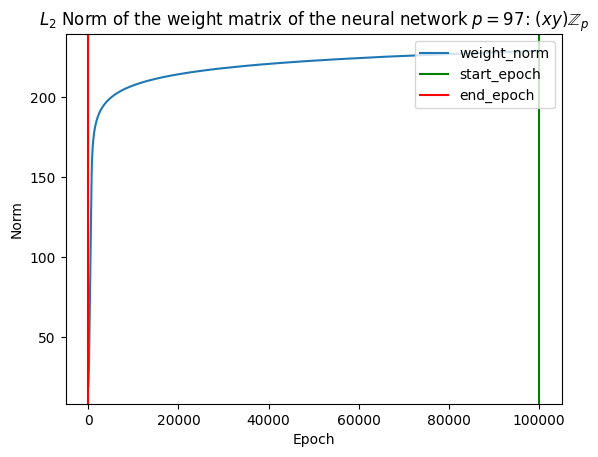

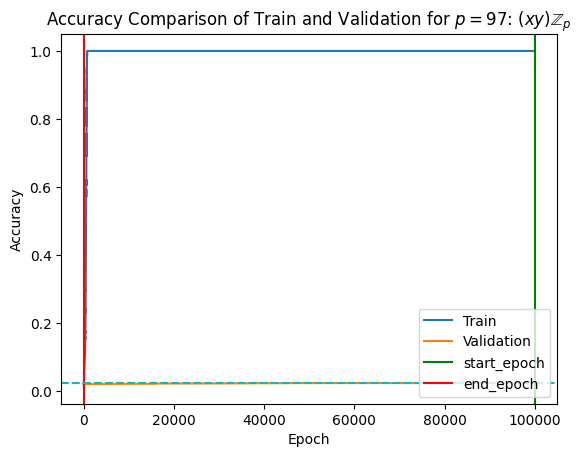

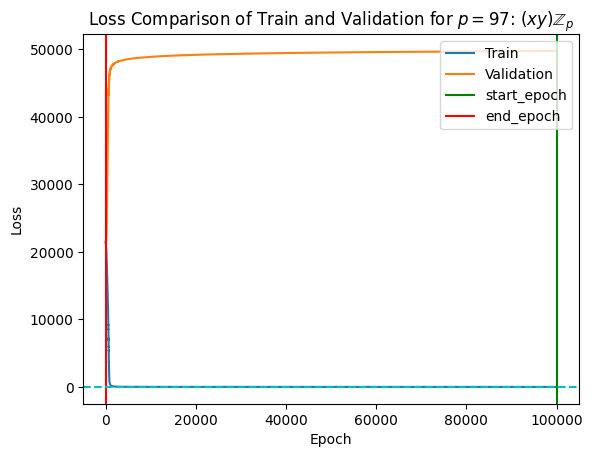

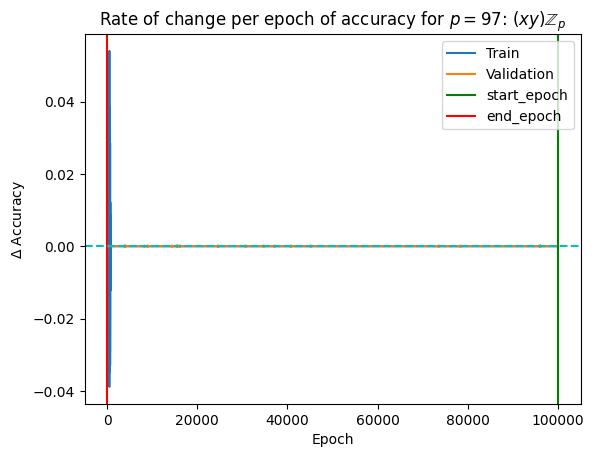

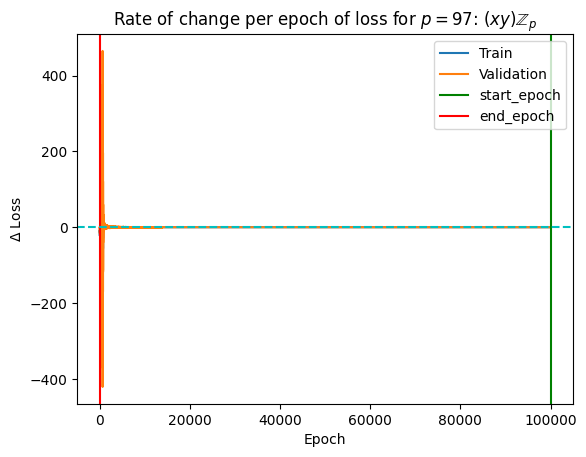

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[(14, 42), (20, 89), (90, 9), (46, 15), (88, 11), (93, 54), (60, 29), (29, 23), (13, 57), (65, 96), (38, 29), (93, 18), (75, 50), (69, 72), (38, 88), (18, 39), (49, 66), (96, 59), (3, 69), (11, 11), (62, 84), (69, 35), (75, 78), (59, 91), (45, 63), (1, 34), (52, 4), (45, 7), (48, 29), (46, 48), (30, 45), (58, 88), (75, 67), (54, 69), (2, 71), (46, 21), (16, 10), (41, 26), (38, 22), (51, 23), (17, 77), (66, 64), (45, 64), (31, 53), (35, 39), (54, 40), (22, 79), (31, 71), (26, 81), (8, 13), (15, 13), (8, 6), (17, 79), (87, 9), (83, 27), (27, 32), (19, 85), (78, 56), (84, 52), (20, 82), (65, 81), (30, 38), (29, 93), (93, 62), (94, 57), (68, 5), (6, 41), (63, 3), (18, 94), (83, 23), (76, 78), (13, 16), (29, 49), (9, 59), (28, 43), (71, 71), (14, 15), (54, 6), (40, 68), (30, 63), (94, 81), (55, 72), (51, 56), (3, 76), (16, 26), (5, 58), (31, 61), (83, 63), (74, 71), (25, 53), (7, 54), (32, 42), (5, 33), (92, 91), (67,

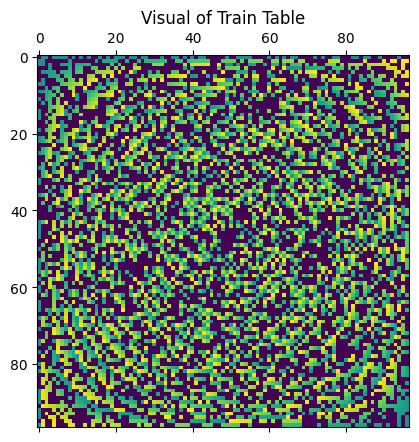

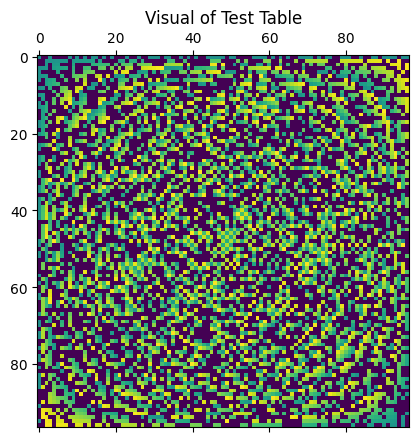

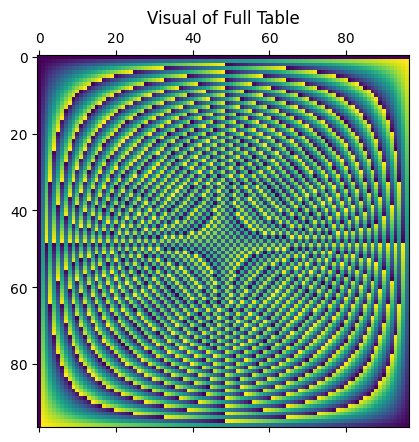

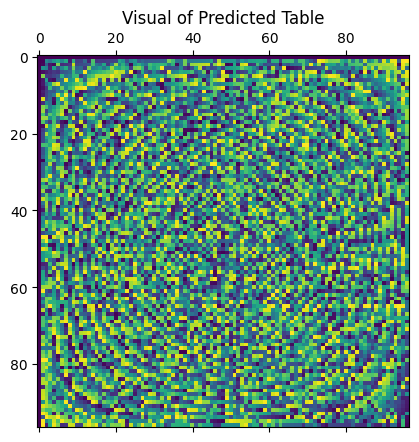


Metric for learning difficulty (New) 0.0012460653584451555


In [9]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
model = MLP_Grok1(prime, hidden_dim)
threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 2 (My method)

  0%|          | 9/100000 [00:00<1:35:35, 17.43it/s] 

Test accuracy  ->  0.008926673792302608
Train accuracy ->  0.013180271722376347


  1%|          | 1011/100000 [00:15<21:20, 77.31it/s] 

Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.1687925159931183


  2%|▏         | 2005/100000 [00:30<36:06, 45.23it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.675595223903656


  3%|▎         | 3006/100000 [00:46<26:13, 61.64it/s]

Test accuracy  ->  0.021891603246331215
Train accuracy ->  0.7727465629577637


  4%|▍         | 4010/100000 [01:09<31:30, 50.78it/s]  

Test accuracy  ->  0.022529223933815956
Train accuracy ->  0.9238945245742798


  5%|▌         | 5010/100000 [01:26<24:17, 65.18it/s]  

Test accuracy  ->  0.024229543283581734
Train accuracy ->  0.9742771983146667


  6%|▌         | 6012/100000 [01:44<30:34, 51.22it/s]

Test accuracy  ->  0.024229543283581734
Train accuracy ->  0.9897959232330322


  7%|▋         | 7006/100000 [02:13<44:31, 34.81it/s]  

Test accuracy  ->  0.02444208227097988
Train accuracy ->  0.9968112111091614


  8%|▊         | 8008/100000 [02:32<23:16, 65.87it/s]

Test accuracy  ->  0.029543038457632065
Train accuracy ->  0.9987244606018066


  9%|▉         | 9009/100000 [02:53<26:00, 58.31it/s]  

Test accuracy  ->  0.031880978494882584
Train accuracy ->  0.9993622303009033


 10%|█         | 10009/100000 [03:14<22:30, 66.64it/s] 

Test accuracy  ->  0.04420828819274902
Train accuracy ->  0.9995747804641724


 11%|█         | 11002/100000 [03:50<1:49:22, 13.56it/s]

Test accuracy  ->  0.05951115861535072
Train accuracy ->  1.0


 12%|█▏        | 12010/100000 [04:27<28:39, 51.18it/s]  

Test accuracy  ->  0.08756641298532486
Train accuracy ->  1.0


 13%|█▎        | 13012/100000 [04:53<21:56, 66.09it/s]  

Test accuracy  ->  0.13071200251579285
Train accuracy ->  1.0


 14%|█▍        | 14007/100000 [05:22<33:35, 42.66it/s]  

Test accuracy  ->  0.1836344301700592
Train accuracy ->  1.0


 15%|█▌        | 15010/100000 [05:41<24:24, 58.03it/s]  

Test accuracy  ->  0.25951114296913147
Train accuracy ->  1.0


 16%|█▌        | 16009/100000 [06:03<29:38, 47.23it/s]  

Test accuracy  ->  0.3356004059314728
Train accuracy ->  1.0


 17%|█▋        | 17005/100000 [06:38<42:12, 32.78it/s]  

Test accuracy  ->  0.4361317753791809
Train accuracy ->  1.0


 18%|█▊        | 18008/100000 [07:02<25:53, 52.77it/s]  

Test accuracy  ->  0.5196599364280701
Train accuracy ->  1.0


 19%|█▉        | 19007/100000 [07:28<32:01, 42.16it/s]  

Test accuracy  ->  0.6327311396598816
Train accuracy ->  1.0


 20%|██        | 20009/100000 [07:59<29:21, 45.42it/s]  

Test accuracy  ->  0.7275238633155823
Train accuracy ->  1.0


 21%|██        | 21009/100000 [08:20<21:00, 62.68it/s]  

Test accuracy  ->  0.8167906403541565
Train accuracy ->  1.0


 22%|██▏       | 22007/100000 [08:43<21:29, 60.50it/s]  

Test accuracy  ->  0.8871412873268127
Train accuracy ->  1.0


 23%|██▎       | 23008/100000 [09:06<21:15, 60.36it/s]  

Test accuracy  ->  0.9266737103462219
Train accuracy ->  1.0


 24%|██▍       | 24011/100000 [09:39<20:41, 61.19it/s]  

Test accuracy  ->  0.9628055095672607
Train accuracy ->  1.0


 25%|██▌       | 25005/100000 [10:06<24:37, 50.77it/s]  

Test accuracy  ->  0.9793835878372192
Train accuracy ->  1.0


 26%|██▌       | 26010/100000 [10:26<21:03, 58.55it/s]

Test accuracy  ->  0.9912858605384827
Train accuracy ->  1.0


 27%|██▋       | 27010/100000 [10:45<21:48, 55.77it/s]  

Test accuracy  ->  0.9951115846633911
Train accuracy ->  1.0


 28%|██▊       | 28008/100000 [11:08<34:04, 35.21it/s]  

Test accuracy  ->  0.9985122084617615
Train accuracy ->  1.0


 29%|██▉       | 29009/100000 [11:33<27:51, 42.48it/s]  

Test accuracy  ->  0.9993623495101929
Train accuracy ->  1.0


 30%|██▉       | 29639/100000 [11:49<28:04, 41.77it/s]  


Early stopping: Test accuracy is 100%

50 % of data for training



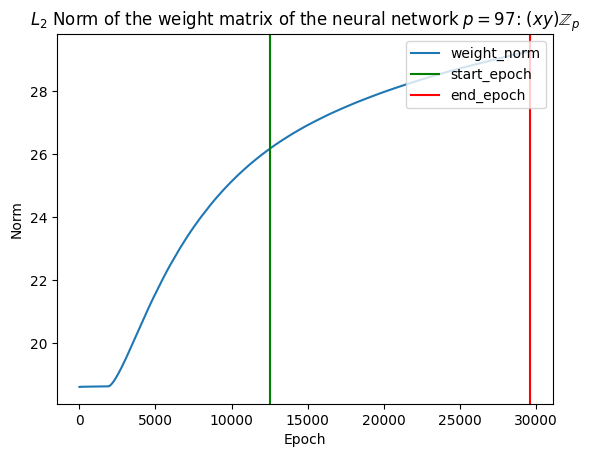

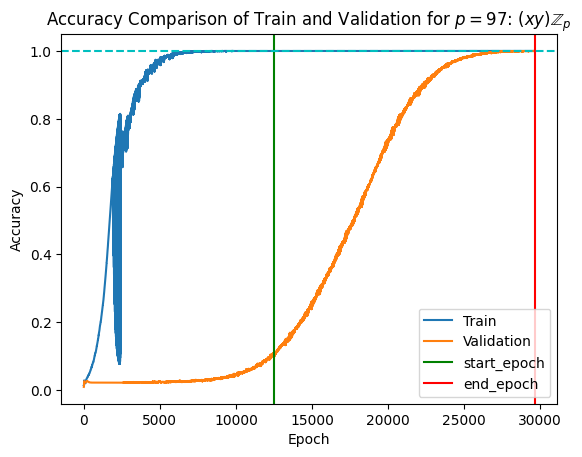

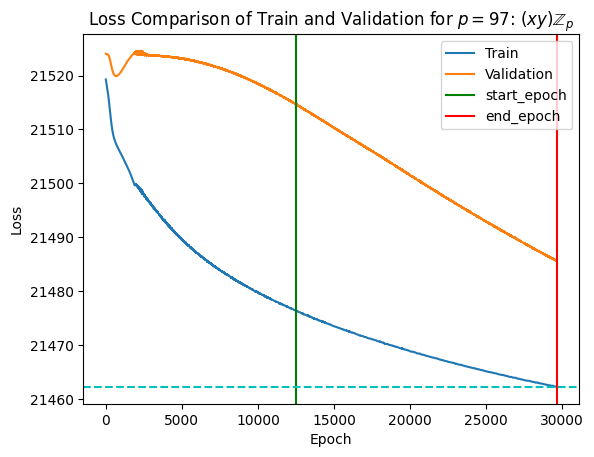

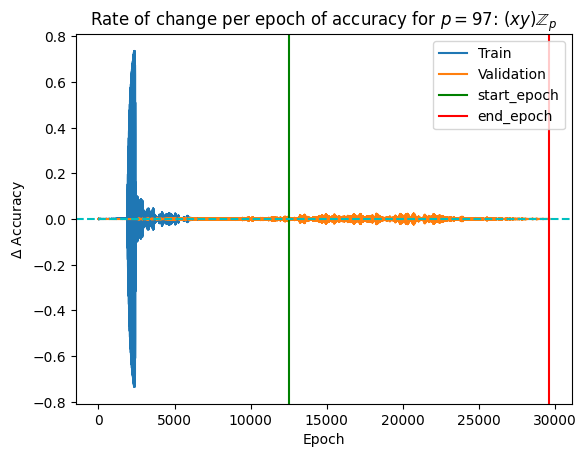

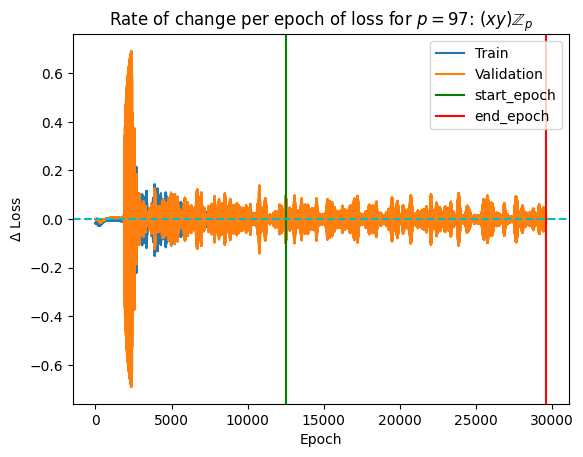

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[]
Metric for learning difficulty (Old) 0.020555384733938618


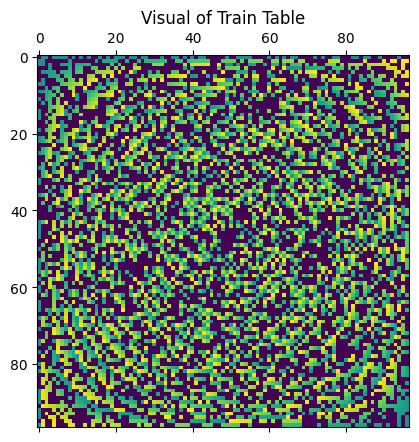

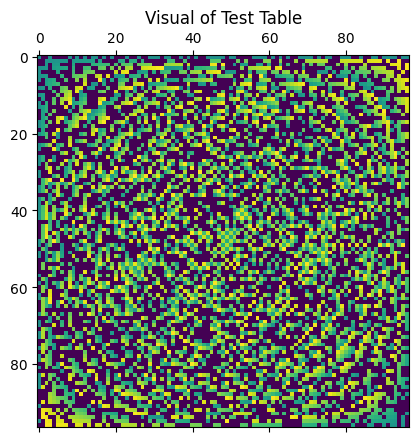

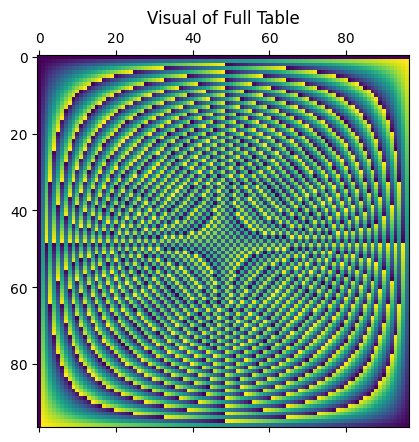

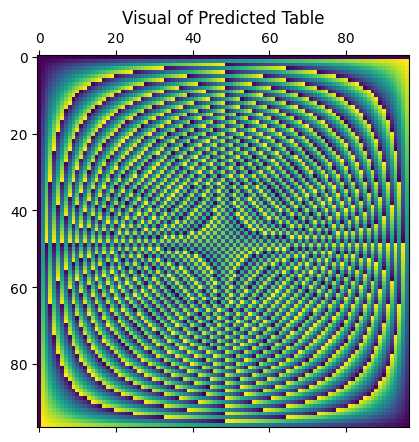


Metric for learning difficulty (New) 0.0012460653584451555


In [10]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime

threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 3

  0%|          | 8/100000 [00:00<54:35, 30.52it/s]  

Test accuracy  ->  0.021679064258933067
Train accuracy ->  0.011692176572978497


  1%|          | 1011/100000 [00:15<21:07, 78.12it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0


  2%|▏         | 2006/100000 [00:30<25:14, 64.72it/s]

Test accuracy  ->  0.13262486457824707
Train accuracy ->  1.0


  3%|▎         | 3003/100000 [00:45<33:05, 48.86it/s]

Test accuracy  ->  0.4865037202835083
Train accuracy ->  1.0


  4%|▍         | 4010/100000 [01:08<26:39, 60.00it/s]  

Test accuracy  ->  0.7755578756332397
Train accuracy ->  1.0


  5%|▌         | 5008/100000 [01:25<30:38, 51.66it/s]

Test accuracy  ->  0.9171094298362732
Train accuracy ->  1.0


  6%|▌         | 6010/100000 [01:46<23:17, 67.27it/s]  

Test accuracy  ->  0.9749202728271484
Train accuracy ->  1.0


  7%|▋         | 7010/100000 [02:04<25:19, 61.21it/s]  

Test accuracy  ->  0.9885228276252747
Train accuracy ->  1.0


  8%|▊         | 8007/100000 [02:26<22:48, 67.24it/s]  

Test accuracy  ->  0.9953240752220154
Train accuracy ->  1.0


  9%|▉         | 9011/100000 [02:47<25:41, 59.04it/s]  

Test accuracy  ->  0.997449517250061
Train accuracy ->  1.0


 10%|█         | 10008/100000 [03:01<22:46, 65.84it/s]

Test accuracy  ->  0.9982996582984924
Train accuracy ->  1.0


 11%|█         | 11010/100000 [03:18<22:31, 65.83it/s]  

Test accuracy  ->  0.9989372491836548
Train accuracy ->  1.0


 12%|█▏        | 12007/100000 [03:35<22:57, 63.86it/s]  

Test accuracy  ->  0.9995748996734619
Train accuracy ->  1.0


 13%|█▎        | 13007/100000 [04:01<21:11, 68.40it/s]  

Test accuracy  ->  0.9995748996734619
Train accuracy ->  1.0


 14%|█▍        | 14008/100000 [04:22<33:25, 42.88it/s]  

Test accuracy  ->  0.999787449836731
Train accuracy ->  1.0


 15%|█▌        | 15005/100000 [04:40<23:42, 59.77it/s]

Test accuracy  ->  0.999787449836731
Train accuracy ->  1.0


 15%|█▌        | 15420/100000 [04:50<26:36, 52.99it/s]  

Early stopping: Test accuracy is 100%



50 % of data for training



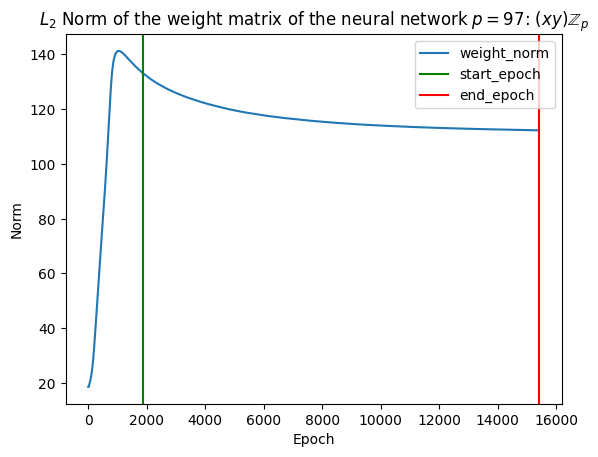

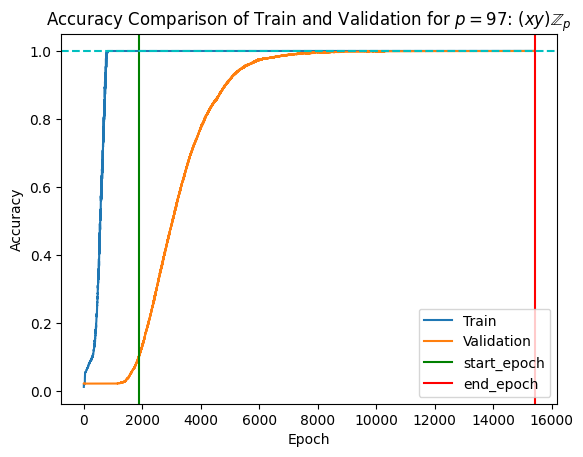

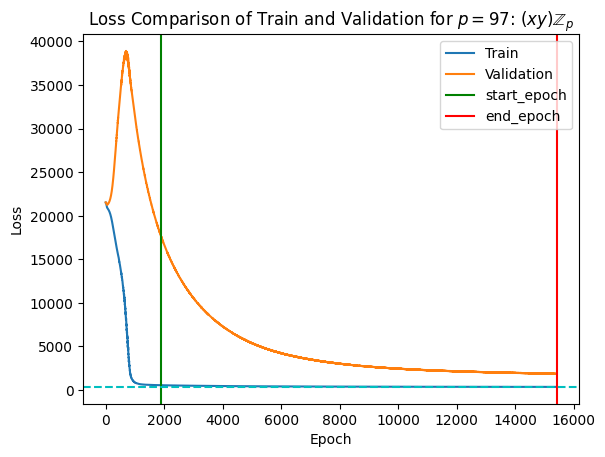

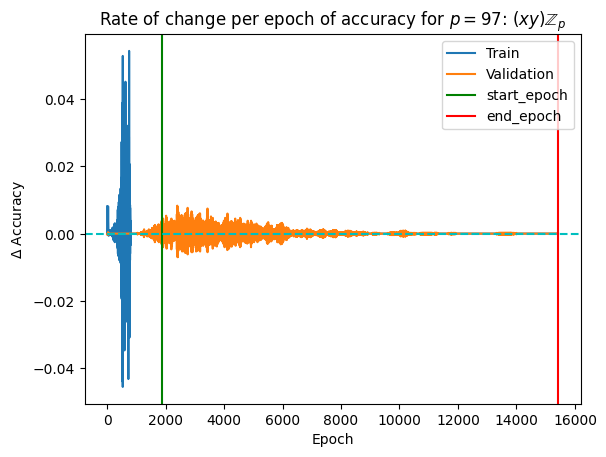

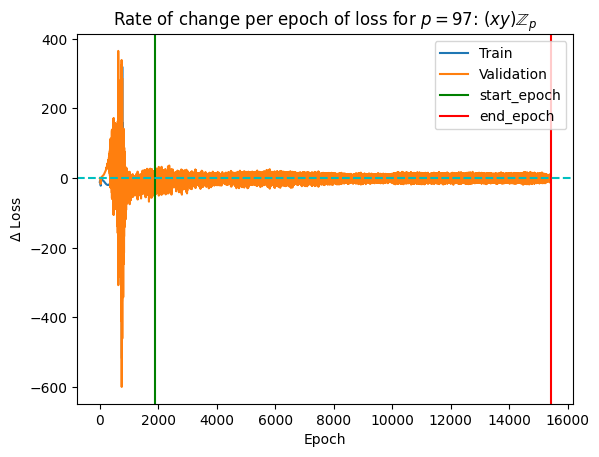

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[]
Metric for learning difficulty (Old) 0.020555384733938618


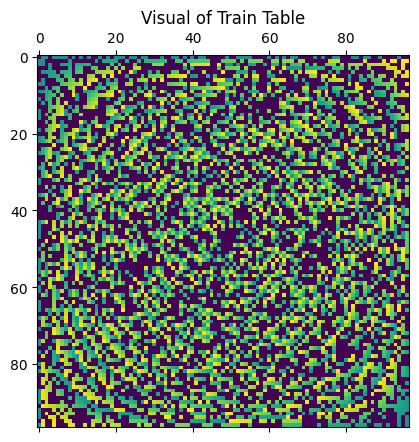

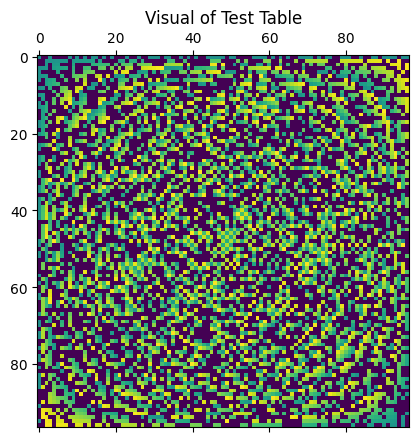

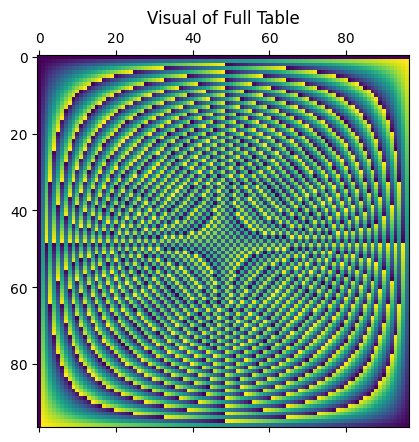

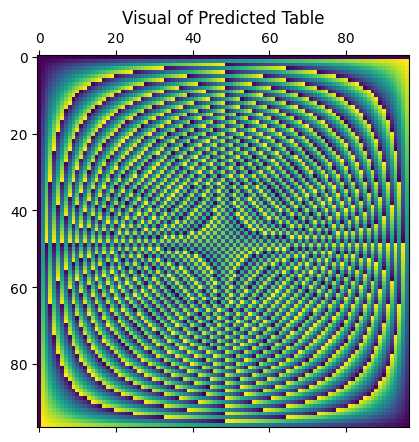


Metric for learning difficulty (New) 0.0012460653584451555


In [11]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
weight_decay = 0.7
threshold1 = 0.9
threshold2 = 1.0
model = MLP_Grok1(prime, hidden_dim)        # Ensuring their is no post logit-activation
run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim, weight_decay = weight_decay)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 4

  0%|          | 18/100000 [00:00<27:58, 59.55it/s] 

Test accuracy  ->  0.025079701095819473
Train accuracy ->  0.010204081423580647


  1%|          | 1009/100000 [00:14<21:31, 76.64it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.9963860511779785


  2%|▏         | 2011/100000 [00:30<33:01, 49.45it/s]  

Test accuracy  ->  0.17024441063404083
Train accuracy ->  0.9995747804641724


  3%|▎         | 3010/100000 [00:46<23:38, 68.40it/s]  

Test accuracy  ->  0.6225292086601257
Train accuracy ->  1.0


  4%|▍         | 4008/100000 [01:03<24:13, 66.03it/s]

Test accuracy  ->  0.9066950082778931
Train accuracy ->  1.0


  5%|▌         | 5009/100000 [01:22<23:51, 66.36it/s]  

Test accuracy  ->  0.9785334467887878
Train accuracy ->  1.0


  6%|▌         | 6005/100000 [01:48<35:25, 44.23it/s]  

Test accuracy  ->  0.9959617257118225
Train accuracy ->  1.0


  7%|▋         | 7009/100000 [02:06<29:10, 53.13it/s]

Test accuracy  ->  0.9987247586250305
Train accuracy ->  1.0


  8%|▊         | 8008/100000 [02:28<28:25, 53.93it/s]  

Test accuracy  ->  0.9995748996734619
Train accuracy ->  1.0
Early stopping: Test accuracy is 100%

50 % of data for training



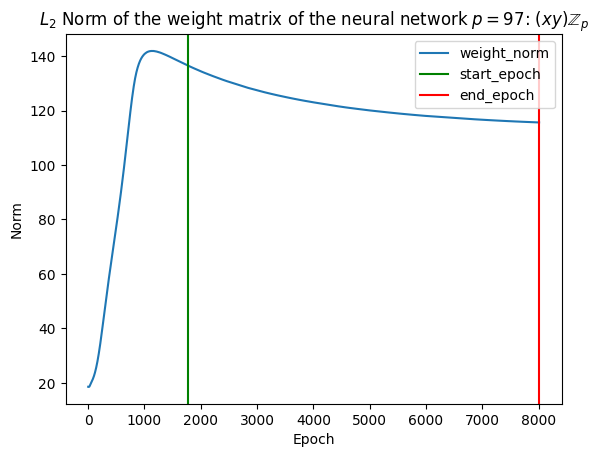

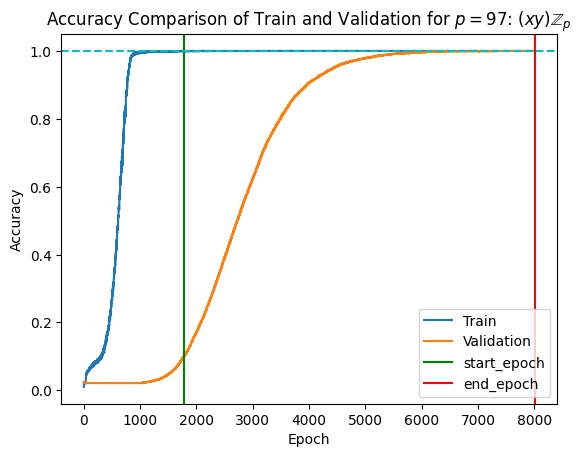

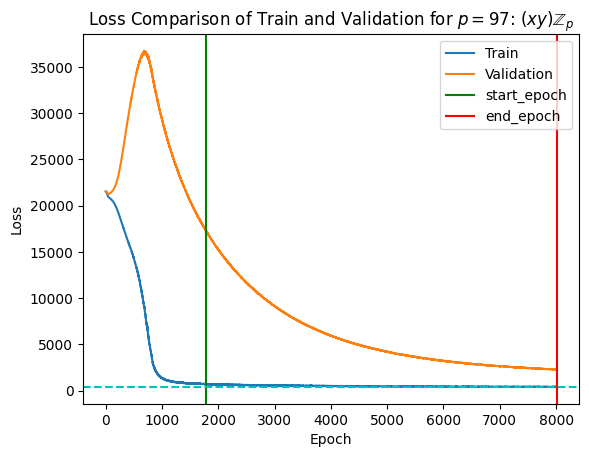

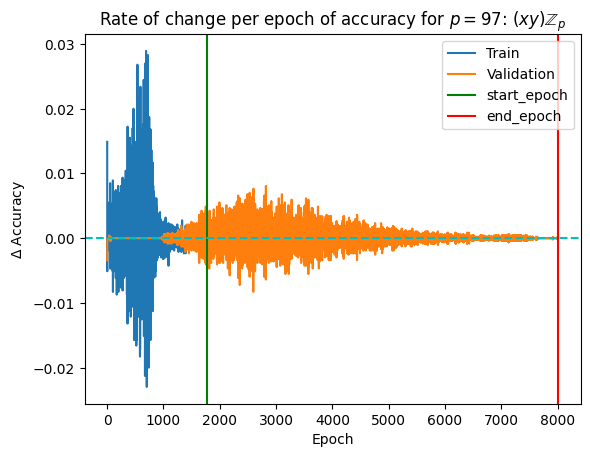

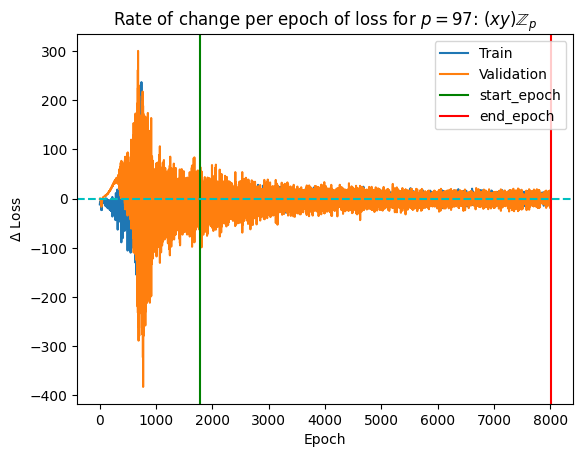

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[]
Metric for learning difficulty (Old) 0.020555384733938618


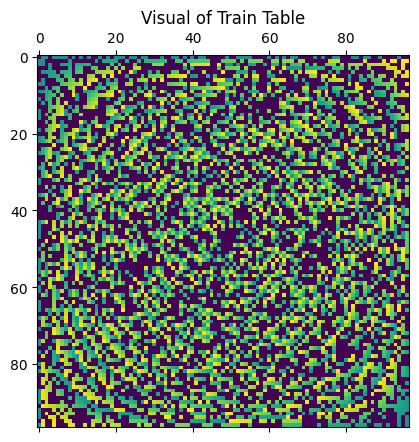

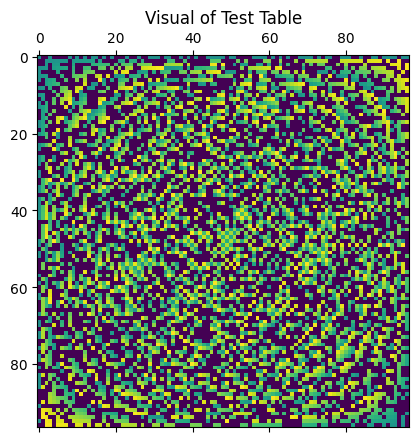

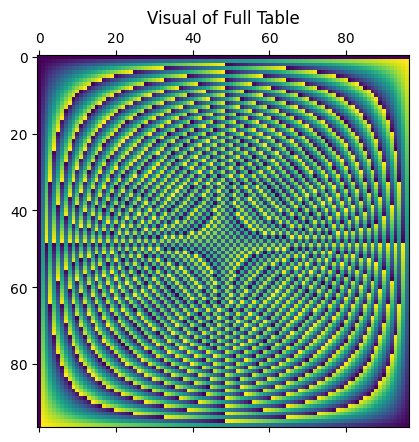

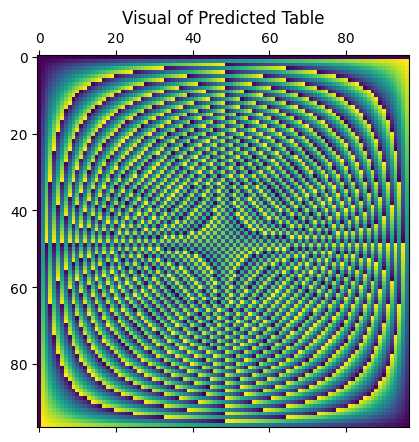


Metric for learning difficulty (New) 0.0012460653584451555


In [12]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
drop_out = 0.1
threshold1 = 0.9
threshold2 = 1.0
model = MLP_Grok3(prime, hidden_dim, drop_out)        # Model with drop out regularisation
run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim, weight_decay = weight_decay)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 5

  0%|          | 8/100000 [00:00<52:28, 31.76it/s]  

Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.011267006397247314


  1%|          | 1008/100000 [00:26<41:21, 39.90it/s] 

Test accuracy  ->  0.027842719107866287
Train accuracy ->  0.03996598720550537


  2%|▏         | 2009/100000 [00:55<28:32, 57.21it/s]  

Test accuracy  ->  0.14473962783813477
Train accuracy ->  0.9919217228889465


  3%|▎         | 3011/100000 [01:16<24:06, 67.07it/s]  

Test accuracy  ->  0.24017003178596497
Train accuracy ->  1.0


  4%|▍         | 4013/100000 [01:34<25:54, 61.76it/s]  

Test accuracy  ->  0.2614240050315857
Train accuracy ->  1.0


  5%|▌         | 5000/100000 [02:01<56:41, 27.93it/s]  

Test accuracy  ->  0.272688627243042
Train accuracy ->  1.0


  6%|▌         | 6014/100000 [02:28<21:33, 72.68it/s]  

Test accuracy  ->  0.28012752532958984
Train accuracy ->  1.0


  7%|▋         | 7009/100000 [02:43<22:47, 67.98it/s]

Test accuracy  ->  0.28777894377708435
Train accuracy ->  1.0


  8%|▊         | 8014/100000 [03:04<23:58, 63.95it/s]  

Test accuracy  ->  0.29415515065193176
Train accuracy ->  1.0


  9%|▉         | 9011/100000 [03:21<24:08, 62.81it/s]

Test accuracy  ->  0.2984059453010559
Train accuracy ->  1.0


 10%|█         | 10005/100000 [03:42<25:53, 57.92it/s] 

Test accuracy  ->  0.30223166942596436
Train accuracy ->  1.0


 11%|█         | 11013/100000 [04:07<23:41, 62.61it/s]  

Test accuracy  ->  0.3056322932243347
Train accuracy ->  1.0


 12%|█▏        | 12007/100000 [04:30<21:58, 66.72it/s]  

Test accuracy  ->  0.30797022581100464
Train accuracy ->  1.0


 13%|█▎        | 13008/100000 [04:51<48:49, 29.69it/s]  

Test accuracy  ->  0.3100956380367279
Train accuracy ->  1.0


 14%|█▍        | 14008/100000 [05:21<19:31, 73.40it/s]  

Test accuracy  ->  0.31264612078666687
Train accuracy ->  1.0


 15%|█▌        | 15008/100000 [05:42<20:01, 70.73it/s]  

Test accuracy  ->  0.3149840533733368
Train accuracy ->  1.0


 16%|█▌        | 16010/100000 [06:00<20:44, 67.47it/s]  

Test accuracy  ->  0.316896915435791
Train accuracy ->  1.0


 17%|█▋        | 17008/100000 [06:20<19:18, 71.64it/s]  

Test accuracy  ->  0.31838467717170715
Train accuracy ->  1.0


 18%|█▊        | 18005/100000 [06:42<36:53, 37.04it/s]  

Test accuracy  ->  0.3200850188732147
Train accuracy ->  1.0


 19%|█▉        | 19004/100000 [07:02<50:22, 26.80it/s]  

Test accuracy  ->  0.3213602602481842
Train accuracy ->  1.0


 20%|██        | 20006/100000 [07:36<29:42, 44.88it/s]  

Test accuracy  ->  0.32199788093566895
Train accuracy ->  1.0


 21%|██        | 21007/100000 [08:02<35:15, 37.34it/s]  

Test accuracy  ->  0.32284802198410034
Train accuracy ->  1.0


 22%|██▏       | 22006/100000 [08:28<28:53, 45.00it/s]  

Test accuracy  ->  0.32518595457077026
Train accuracy ->  1.0


 23%|██▎       | 23007/100000 [08:47<20:48, 61.66it/s]  

Test accuracy  ->  0.325823575258255
Train accuracy ->  1.0


 24%|██▍       | 24004/100000 [09:05<53:24, 23.71it/s]

Test accuracy  ->  0.32731136679649353
Train accuracy ->  1.0


 25%|██▌       | 25012/100000 [09:22<18:08, 68.91it/s]

Test accuracy  ->  0.32879912853240967
Train accuracy ->  1.0


 26%|██▌       | 26008/100000 [09:42<17:57, 68.70it/s]  

Test accuracy  ->  0.33134961128234863
Train accuracy ->  1.0


 27%|██▋       | 27012/100000 [10:05<20:57, 58.02it/s]  

Test accuracy  ->  0.3334750235080719
Train accuracy ->  1.0


 28%|██▊       | 28006/100000 [10:22<18:54, 63.47it/s]

Test accuracy  ->  0.33411264419555664
Train accuracy ->  1.0


 29%|██▉       | 29010/100000 [10:39<18:56, 62.47it/s]

Test accuracy  ->  0.33602550625801086
Train accuracy ->  1.0


 30%|███       | 30002/100000 [11:11<2:16:37,  8.54it/s]

Test accuracy  ->  0.33645057678222656
Train accuracy ->  1.0


 31%|███       | 31007/100000 [11:43<15:06, 76.07it/s]  

Test accuracy  ->  0.3379383683204651
Train accuracy ->  1.0


 32%|███▏      | 32010/100000 [12:09<26:09, 43.33it/s]  

Test accuracy  ->  0.33857598900794983
Train accuracy ->  1.0


 33%|███▎      | 33004/100000 [12:38<36:08, 30.90it/s]  

Test accuracy  ->  0.33857598900794983
Train accuracy ->  1.0


 34%|███▍      | 34008/100000 [12:59<18:20, 59.98it/s]  

Test accuracy  ->  0.3398512005805969
Train accuracy ->  1.0


 35%|███▌      | 35010/100000 [13:18<16:35, 65.29it/s]  

Test accuracy  ->  0.340276300907135
Train accuracy ->  1.0


 36%|███▌      | 36005/100000 [13:42<32:30, 32.81it/s]  

Test accuracy  ->  0.3415515422821045
Train accuracy ->  1.0


 37%|███▋      | 37017/100000 [14:03<15:55, 65.93it/s]

Test accuracy  ->  0.34261423349380493
Train accuracy ->  1.0


 38%|███▊      | 38007/100000 [14:30<26:54, 38.40it/s]  

Test accuracy  ->  0.3432518541812897
Train accuracy ->  1.0


 39%|███▉      | 39009/100000 [14:49<19:49, 51.29it/s]

Test accuracy  ->  0.34410202503204346
Train accuracy ->  1.0


 40%|████      | 40014/100000 [15:11<14:40, 68.12it/s]

Test accuracy  ->  0.3451647162437439
Train accuracy ->  1.0


 41%|████      | 41006/100000 [15:43<27:42, 35.49it/s]  

Test accuracy  ->  0.3455897867679596
Train accuracy ->  1.0


 42%|████▏     | 42007/100000 [16:05<20:39, 46.79it/s]  

Test accuracy  ->  0.34622740745544434
Train accuracy ->  1.0


 43%|████▎     | 43005/100000 [16:26<21:18, 44.58it/s]  

Test accuracy  ->  0.3470775783061981
Train accuracy ->  1.0


 44%|████▍     | 44004/100000 [16:54<43:09, 21.62it/s]  

Test accuracy  ->  0.34771519899368286
Train accuracy ->  1.0


 45%|████▌     | 45005/100000 [17:26<24:27, 37.48it/s]  

Test accuracy  ->  0.34899044036865234
Train accuracy ->  1.0


 46%|████▌     | 46003/100000 [17:55<23:27, 38.36it/s]  

Test accuracy  ->  0.3496280610561371
Train accuracy ->  1.0


 47%|████▋     | 47003/100000 [18:21<28:13, 31.29it/s]

Test accuracy  ->  0.3504782021045685
Train accuracy ->  1.0


 48%|████▊     | 48007/100000 [18:48<21:31, 40.25it/s]

Test accuracy  ->  0.3506907522678375
Train accuracy ->  1.0


 49%|████▉     | 49010/100000 [19:21<14:43, 57.69it/s]  

Test accuracy  ->  0.3511158227920532
Train accuracy ->  1.0


 50%|█████     | 50004/100000 [19:49<21:29, 38.78it/s]  

Test accuracy  ->  0.35175344347953796
Train accuracy ->  1.0


 51%|█████     | 51005/100000 [20:24<27:49, 29.35it/s]  

Test accuracy  ->  0.35260361433029175
Train accuracy ->  1.0


 52%|█████▏    | 52007/100000 [20:48<21:33, 37.09it/s]

Test accuracy  ->  0.35302868485450745
Train accuracy ->  1.0


 53%|█████▎    | 53008/100000 [21:15<21:32, 36.37it/s]  

Test accuracy  ->  0.3528161346912384
Train accuracy ->  1.0


 54%|█████▍    | 54005/100000 [21:47<33:31, 22.86it/s]  

Test accuracy  ->  0.3532412350177765
Train accuracy ->  1.0


 55%|█████▌    | 55009/100000 [22:21<09:59, 75.05it/s]  

Test accuracy  ->  0.35387885570526123
Train accuracy ->  1.0


 56%|█████▌    | 56009/100000 [22:36<12:27, 58.85it/s]

Test accuracy  ->  0.35387885570526123
Train accuracy ->  1.0


 57%|█████▋    | 57006/100000 [23:04<11:42, 61.24it/s]  

Test accuracy  ->  0.3547289967536926
Train accuracy ->  1.0


 58%|█████▊    | 58006/100000 [23:26<20:46, 33.70it/s]

Test accuracy  ->  0.35494154691696167
Train accuracy ->  1.0


 59%|█████▉    | 59007/100000 [23:51<17:03, 40.04it/s]  

Test accuracy  ->  0.3551540970802307
Train accuracy ->  1.0


 60%|██████    | 60009/100000 [24:18<10:27, 63.70it/s]

Test accuracy  ->  0.3560042381286621
Train accuracy ->  1.0


 61%|██████    | 61006/100000 [24:52<08:01, 80.94it/s]  

Test accuracy  ->  0.35621678829193115
Train accuracy ->  1.0


 62%|██████▏   | 62004/100000 [25:12<32:01, 19.78it/s]

Test accuracy  ->  0.35664185881614685
Train accuracy ->  1.0


 63%|██████▎   | 63005/100000 [25:40<11:20, 54.40it/s]

Test accuracy  ->  0.3568544089794159
Train accuracy ->  1.0


 64%|██████▍   | 64003/100000 [26:04<28:55, 20.74it/s]

Test accuracy  ->  0.3572794795036316
Train accuracy ->  1.0


 65%|██████▌   | 65008/100000 [26:39<08:34, 67.97it/s]

Test accuracy  ->  0.35791710019111633
Train accuracy ->  1.0


 66%|██████▌   | 66007/100000 [27:15<16:08, 35.10it/s]  

Test accuracy  ->  0.3585547208786011
Train accuracy ->  1.0


 67%|██████▋   | 67008/100000 [27:31<08:32, 64.37it/s]

Test accuracy  ->  0.35940489172935486
Train accuracy ->  1.0


 68%|██████▊   | 68009/100000 [27:50<09:21, 56.95it/s]

Test accuracy  ->  0.35982996225357056
Train accuracy ->  1.0


 69%|██████▉   | 69005/100000 [28:17<12:01, 42.93it/s]

Test accuracy  ->  0.360892653465271
Train accuracy ->  1.0


 70%|███████   | 70004/100000 [28:46<18:26, 27.11it/s]

Test accuracy  ->  0.36110520362854004
Train accuracy ->  1.0


 71%|███████   | 71004/100000 [29:10<41:50, 11.55it/s]

Test accuracy  ->  0.36153027415275574
Train accuracy ->  1.0


 72%|███████▏  | 72006/100000 [29:41<15:49, 29.47it/s]

Test accuracy  ->  0.36153027415275574
Train accuracy ->  1.0


 73%|███████▎  | 73004/100000 [30:13<20:43, 21.72it/s]

Test accuracy  ->  0.3617428243160248
Train accuracy ->  1.0


 74%|███████▍  | 74005/100000 [30:40<08:42, 49.75it/s]

Test accuracy  ->  0.3621678948402405
Train accuracy ->  1.0


 75%|███████▌  | 75008/100000 [31:05<08:25, 49.42it/s]

Test accuracy  ->  0.3623804450035095
Train accuracy ->  1.0


 76%|███████▌  | 76010/100000 [31:28<07:47, 51.32it/s]

Test accuracy  ->  0.3628055155277252
Train accuracy ->  1.0


 77%|███████▋  | 77010/100000 [31:50<08:29, 45.13it/s]

Test accuracy  ->  0.36301806569099426
Train accuracy ->  1.0


 78%|███████▊  | 78005/100000 [32:22<08:53, 41.24it/s]

Test accuracy  ->  0.36301806569099426
Train accuracy ->  1.0


 79%|███████▉  | 79007/100000 [32:45<06:23, 54.70it/s]

Test accuracy  ->  0.36301806569099426
Train accuracy ->  1.0


 80%|████████  | 80009/100000 [33:09<04:48, 69.20it/s]

Test accuracy  ->  0.36301806569099426
Train accuracy ->  1.0


 81%|████████  | 81007/100000 [33:33<06:34, 48.18it/s]

Test accuracy  ->  0.3628055155277252
Train accuracy ->  1.0


 82%|████████▏ | 82011/100000 [33:58<05:19, 56.26it/s]

Test accuracy  ->  0.36301806569099426
Train accuracy ->  1.0


 83%|████████▎ | 83006/100000 [34:23<08:27, 33.51it/s]

Test accuracy  ->  0.36344313621520996
Train accuracy ->  1.0


 84%|████████▍ | 84006/100000 [34:48<06:09, 43.25it/s]

Test accuracy  ->  0.363655686378479
Train accuracy ->  1.0


 85%|████████▌ | 85004/100000 [35:11<06:38, 37.63it/s]

Test accuracy  ->  0.36386820673942566
Train accuracy ->  1.0


 86%|████████▌ | 86008/100000 [35:40<04:50, 48.16it/s]

Test accuracy  ->  0.36386820673942566
Train accuracy ->  1.0


 87%|████████▋ | 87009/100000 [36:07<03:47, 57.10it/s]

Test accuracy  ->  0.36386820673942566
Train accuracy ->  1.0


 88%|████████▊ | 88005/100000 [36:32<03:00, 66.54it/s]

Test accuracy  ->  0.36429330706596375
Train accuracy ->  1.0


 89%|████████▉ | 89006/100000 [36:56<04:15, 43.08it/s]

Test accuracy  ->  0.3649309277534485
Train accuracy ->  1.0


 90%|█████████ | 90004/100000 [37:26<03:58, 41.94it/s]

Test accuracy  ->  0.3649309277534485
Train accuracy ->  1.0


 91%|█████████ | 91007/100000 [37:49<02:02, 73.44it/s]

Test accuracy  ->  0.3653559982776642
Train accuracy ->  1.0


 92%|█████████▏| 92009/100000 [38:14<02:36, 51.05it/s]

Test accuracy  ->  0.3657810688018799
Train accuracy ->  1.0


 93%|█████████▎| 93007/100000 [38:43<02:19, 50.05it/s]

Test accuracy  ->  0.3664186894893646
Train accuracy ->  1.0


 94%|█████████▍| 94003/100000 [39:11<04:17, 23.25it/s]

Test accuracy  ->  0.36663123965263367
Train accuracy ->  1.0


 95%|█████████▌| 95008/100000 [39:35<02:04, 40.04it/s]

Test accuracy  ->  0.3668437600135803
Train accuracy ->  1.0


 96%|█████████▌| 96013/100000 [39:59<01:24, 47.31it/s]

Test accuracy  ->  0.3668437600135803
Train accuracy ->  1.0


 97%|█████████▋| 97000/100000 [40:26<00:52, 57.50it/s]

Test accuracy  ->  0.36705631017684937
Train accuracy ->  1.0


 98%|█████████▊| 98009/100000 [40:50<00:36, 54.27it/s]

Test accuracy  ->  0.36705631017684937
Train accuracy ->  1.0


 99%|█████████▉| 99013/100000 [41:17<00:15, 63.99it/s]

Test accuracy  ->  0.36705631017684937
Train accuracy ->  1.0


100%|██████████| 100000/100000 [41:36<00:00, 40.06it/s]


threshold1 and threshold2 not reached

Largest gap between accuracies of train and test is 0.8529194891452789 at epoch 1973

Highest test accuracy is 0.36705631017684937 at epoch 96589

50 % of data for training



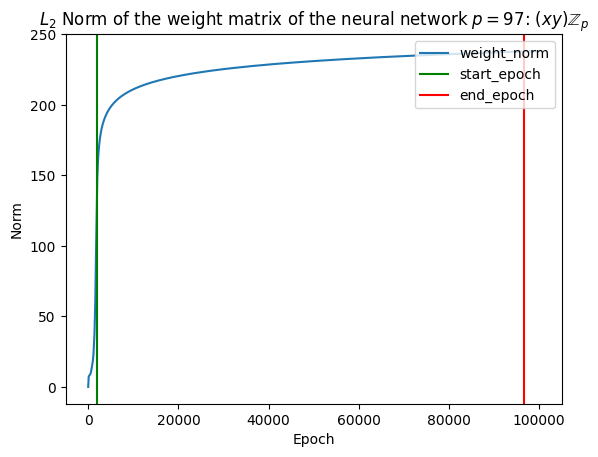

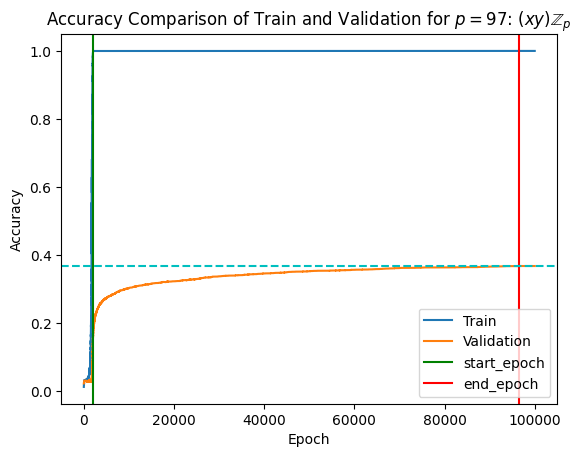

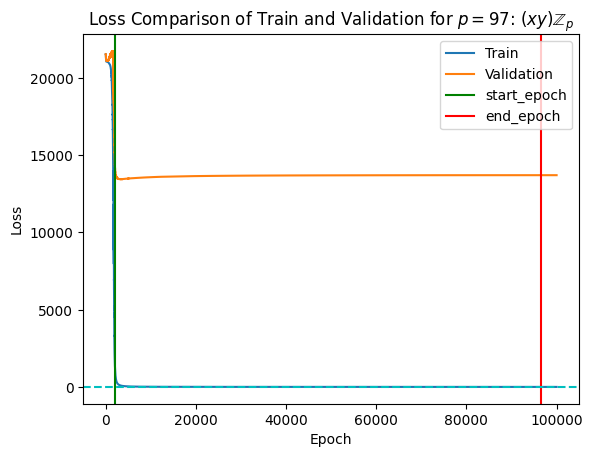

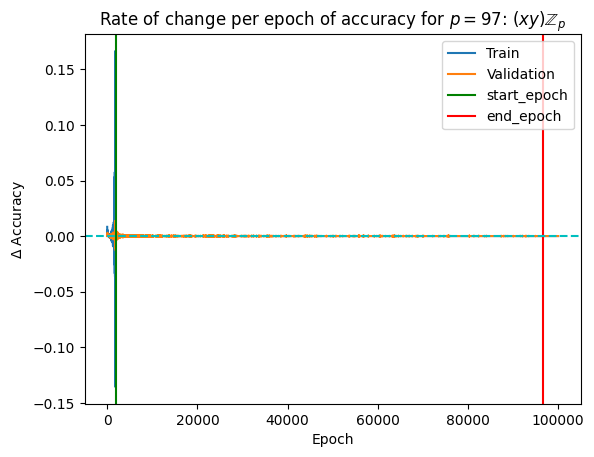

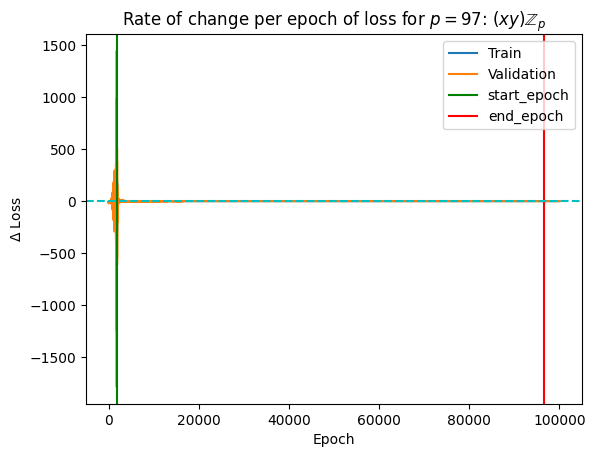

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[(14, 42), (20, 89), (90, 9), (46, 15), (88, 11), (60, 29), (29, 23), (13, 57), (65, 96), (93, 18), (69, 72), (18, 39), (56, 6), (11, 11), (62, 84), (75, 78), (1, 34), (45, 7), (46, 48), (58, 88), (54, 69), (2, 71), (16, 10), (38, 22), (51, 23), (17, 77), (66, 64), (45, 64), (31, 53), (35, 39), (22, 79), (31, 71), (8, 13), (17, 79), (87, 9), (83, 27), (27, 32), (84, 52), (20, 82), (29, 93), (15, 89), (83, 23), (13, 16), (29, 49), (9, 59), (28, 43), (54, 6), (30, 63), (94, 81), (51, 56), (3, 76), (5, 58), (31, 61), (83, 63), (74, 71), (72, 27), (34, 72), (44, 71), (12, 16), (28, 37), (3, 24), (87, 81), (70, 72), (15, 95), (17, 72), (77, 82), (90, 59), (90, 3), (65, 89), (40, 4), (11, 80), (25, 73), (51, 3), (75, 29), (41, 45), (68, 91), (33, 94), (42, 74), (95, 79), (65, 88), (2, 73), (7, 86), (83, 90), (56, 33), (14, 48), (21, 8), (56, 70), (17, 90), (8, 95), (35, 75), (31, 14), (16, 41), (71, 35), (74, 39), (26,

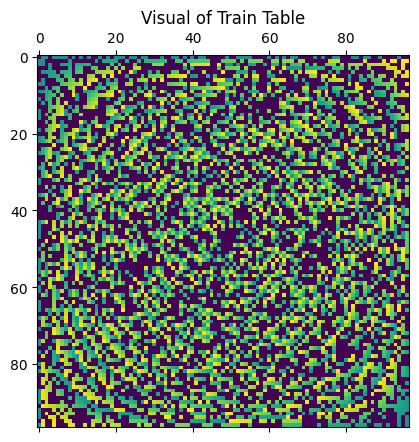

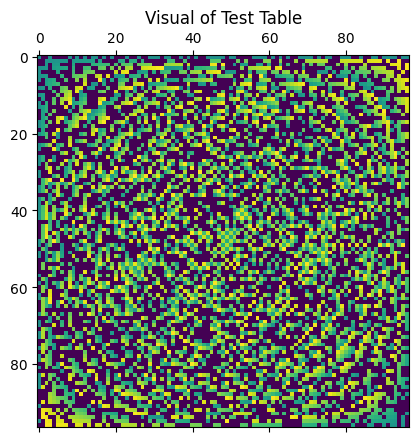

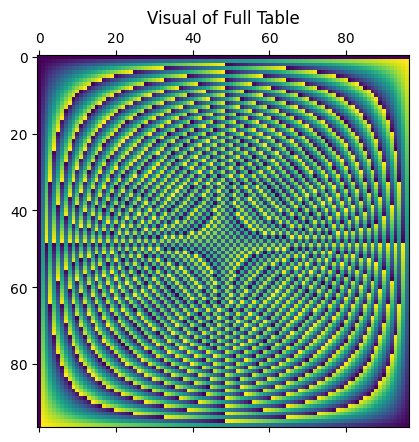

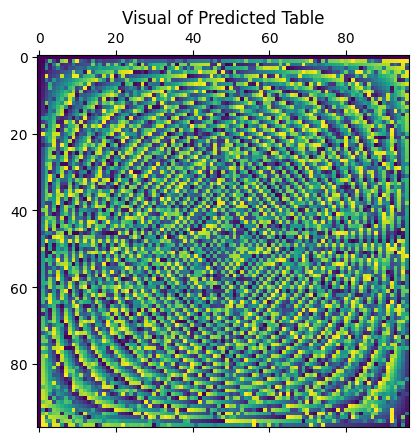


Metric for learning difficulty (New) 0.0012460653584451555


In [13]:
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
model = MLP_Grok1(prime, hidden_dim)            # Model without post-logit activation

with torch.no_grad():
    for name, W in model.named_parameters():
        if 'weight' in name:
            W /= 100_000

threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

### Method 6 (Prieto et al.)

  0%|          | 7/100000 [00:00<1:17:16, 21.56it/s]

Test accuracy  ->  0.024867162108421326
Train accuracy ->  0.013180271722376347


  1%|          | 1010/100000 [00:15<32:15, 51.16it/s]

Test accuracy  ->  0.02146652527153492
Train accuracy ->  0.9468536972999573


  2%|▏         | 2008/100000 [00:37<33:32, 48.70it/s]  

Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0


  3%|▎         | 3004/100000 [01:15<58:36, 27.59it/s]  

Test accuracy  ->  0.02146652527153492
Train accuracy ->  1.0


  4%|▍         | 4004/100000 [01:37<39:46, 40.22it/s]  

Test accuracy  ->  0.021891603246331215
Train accuracy ->  1.0


  5%|▌         | 5011/100000 [02:14<32:27, 48.77it/s]  

Test accuracy  ->  0.02231668308377266
Train accuracy ->  1.0


  6%|▌         | 6004/100000 [02:42<2:02:21, 12.80it/s]

Test accuracy  ->  0.022529223933815956
Train accuracy ->  1.0


  7%|▋         | 7003/100000 [03:19<1:34:32, 16.39it/s]

Test accuracy  ->  0.022529223933815956
Train accuracy ->  1.0


  8%|▊         | 8008/100000 [03:44<38:04, 40.27it/s]  

Test accuracy  ->  0.023591922596096992
Train accuracy ->  1.0


  9%|▉         | 9005/100000 [04:08<43:16, 35.04it/s]  

Test accuracy  ->  0.024017002433538437
Train accuracy ->  1.0


 10%|█         | 10002/100000 [04:47<1:19:58, 18.76it/s]

Test accuracy  ->  0.024017002433538437
Train accuracy ->  1.0


 11%|█         | 11005/100000 [05:22<52:58, 28.00it/s]  

Test accuracy  ->  0.025079701095819473
Train accuracy ->  1.0


 12%|█▏        | 12003/100000 [06:02<1:05:12, 22.49it/s]

Test accuracy  ->  0.02614240162074566
Train accuracy ->  1.0


 13%|█▎        | 13006/100000 [06:37<1:04:46, 22.38it/s]

Test accuracy  ->  0.026354940608143806
Train accuracy ->  1.0


 14%|█▍        | 14005/100000 [07:14<53:26, 26.82it/s]  

Test accuracy  ->  0.026567481458187103
Train accuracy ->  1.0


 15%|█▌        | 15011/100000 [07:50<27:47, 50.96it/s]  

Test accuracy  ->  0.02763018012046814
Train accuracy ->  1.0


 16%|█▌        | 16010/100000 [08:28<47:00, 29.78it/s]  

Test accuracy  ->  0.02911795862019062
Train accuracy ->  1.0


 17%|█▋        | 17008/100000 [08:59<29:16, 47.25it/s]  

Test accuracy  ->  0.02996811829507351
Train accuracy ->  1.0


 18%|█▊        | 18013/100000 [09:34<27:26, 49.78it/s]  

Test accuracy  ->  0.0306057371199131
Train accuracy ->  1.0


 19%|█▉        | 19005/100000 [10:14<32:25, 41.63it/s]  

Test accuracy  ->  0.0306057371199131
Train accuracy ->  1.0


 20%|██        | 20005/100000 [10:41<35:59, 37.04it/s]  

Test accuracy  ->  0.031243357807397842
Train accuracy ->  1.0


 21%|██        | 21005/100000 [11:17<1:00:51, 21.63it/s]

Test accuracy  ->  0.03145589679479599
Train accuracy ->  1.0


 22%|██▏       | 22005/100000 [11:48<27:20, 47.54it/s]  

Test accuracy  ->  0.03230605646967888
Train accuracy ->  1.0


 23%|██▎       | 23006/100000 [12:15<25:35, 50.13it/s]  

Test accuracy  ->  0.032518595457077026
Train accuracy ->  1.0


 24%|██▍       | 24003/100000 [12:43<31:55, 39.68it/s]  

Test accuracy  ->  0.03358129411935806
Train accuracy ->  1.0


 25%|██▌       | 25002/100000 [13:27<53:50, 23.22it/s]  

Test accuracy  ->  0.03379383683204651
Train accuracy ->  1.0


 26%|██▌       | 26008/100000 [14:08<22:07, 55.74it/s]  

Test accuracy  ->  0.03443145379424095
Train accuracy ->  1.0


 27%|██▋       | 27009/100000 [14:37<29:49, 40.79it/s]  

Test accuracy  ->  0.03506907448172569
Train accuracy ->  1.0


 28%|██▊       | 28004/100000 [15:15<1:12:18, 16.60it/s]

Test accuracy  ->  0.03528161346912384
Train accuracy ->  1.0


 29%|██▉       | 29004/100000 [15:44<58:37, 20.18it/s]  

Test accuracy  ->  0.035706695169210434
Train accuracy ->  1.0


 30%|███       | 30004/100000 [16:18<1:15:46, 15.40it/s]

Test accuracy  ->  0.03591923415660858
Train accuracy ->  1.0


 31%|███       | 31006/100000 [16:53<20:29, 56.10it/s]  

Test accuracy  ->  0.03634431213140488
Train accuracy ->  1.0


 32%|███▏      | 32004/100000 [17:18<34:19, 33.02it/s]  

Test accuracy  ->  0.03655685484409332
Train accuracy ->  1.0


 33%|███▎      | 33002/100000 [17:51<34:39, 32.21it/s]  

Test accuracy  ->  0.03698193281888962
Train accuracy ->  1.0


 34%|███▍      | 34006/100000 [18:26<26:26, 41.60it/s]  

Test accuracy  ->  0.03761955350637436
Train accuracy ->  1.0


 35%|███▌      | 35009/100000 [18:57<20:47, 52.10it/s]  

Test accuracy  ->  0.03783209249377251
Train accuracy ->  1.0


 36%|███▌      | 36008/100000 [19:29<20:28, 52.08it/s]  

Test accuracy  ->  0.03846971318125725
Train accuracy ->  1.0


 37%|███▋      | 37003/100000 [20:08<37:57, 27.66it/s]  

Test accuracy  ->  0.038682252168655396
Train accuracy ->  1.0


 38%|███▊      | 38007/100000 [20:34<30:44, 33.61it/s]  

Test accuracy  ->  0.03889479115605354
Train accuracy ->  1.0


 39%|███▉      | 39006/100000 [21:05<25:21, 40.09it/s]  

Test accuracy  ->  0.039532411843538284
Train accuracy ->  1.0


 40%|████      | 40007/100000 [21:40<38:56, 25.67it/s]  

Test accuracy  ->  0.040170032531023026
Train accuracy ->  1.0


 41%|████      | 41008/100000 [22:10<20:41, 47.50it/s]  

Test accuracy  ->  0.041020188480615616
Train accuracy ->  1.0


 42%|████▏     | 42008/100000 [22:39<24:41, 39.14it/s]  

Test accuracy  ->  0.04144527018070221
Train accuracy ->  1.0


 43%|████▎     | 43009/100000 [23:09<25:00, 37.97it/s]  

Test accuracy  ->  0.04208289086818695
Train accuracy ->  1.0


 44%|████▍     | 44004/100000 [24:02<57:28, 16.24it/s]  

Test accuracy  ->  0.0422954298555851
Train accuracy ->  1.0


 45%|████▌     | 45005/100000 [24:39<19:09, 47.85it/s]  

Test accuracy  ->  0.04293305054306984
Train accuracy ->  1.0


 46%|████▌     | 46010/100000 [24:59<18:13, 49.37it/s]

Test accuracy  ->  0.04378320649266243
Train accuracy ->  1.0


 47%|████▋     | 47003/100000 [25:34<56:17, 15.69it/s]

Test accuracy  ->  0.04463336616754532
Train accuracy ->  1.0


 48%|████▊     | 48011/100000 [26:10<18:29, 46.86it/s]  

Test accuracy  ->  0.04569606855511665
Train accuracy ->  1.0


 49%|████▉     | 49010/100000 [26:33<12:25, 68.44it/s]

Test accuracy  ->  0.04569606855511665
Train accuracy ->  1.0


 50%|█████     | 50009/100000 [26:50<13:54, 59.90it/s]

Test accuracy  ->  0.04569606855511665
Train accuracy ->  1.0


 51%|█████     | 51007/100000 [27:15<12:57, 62.99it/s]

Test accuracy  ->  0.0459086075425148
Train accuracy ->  1.0


 52%|█████▏    | 52004/100000 [27:35<17:11, 46.53it/s]

Test accuracy  ->  0.0459086075425148
Train accuracy ->  1.0


 53%|█████▎    | 53006/100000 [28:03<22:02, 35.53it/s]

Test accuracy  ->  0.04675876721739769
Train accuracy ->  1.0


 54%|█████▍    | 54007/100000 [28:26<12:42, 60.33it/s]

Test accuracy  ->  0.04697130620479584
Train accuracy ->  1.0


 55%|█████▌    | 55008/100000 [28:52<12:09, 61.70it/s]

Test accuracy  ->  0.04739638417959213
Train accuracy ->  1.0


 56%|█████▌    | 56014/100000 [29:10<11:19, 64.69it/s]

Test accuracy  ->  0.047821465879678726
Train accuracy ->  1.0


 57%|█████▋    | 57006/100000 [29:38<24:41, 29.03it/s]

Test accuracy  ->  0.048034004867076874
Train accuracy ->  1.0


 58%|█████▊    | 58011/100000 [30:12<11:13, 62.39it/s]  

Test accuracy  ->  0.048034004867076874
Train accuracy ->  1.0


 59%|█████▉    | 59009/100000 [30:36<11:33, 59.09it/s]

Test accuracy  ->  0.04824654385447502
Train accuracy ->  1.0


 60%|██████    | 60011/100000 [30:56<13:51, 48.08it/s]

Test accuracy  ->  0.048671625554561615
Train accuracy ->  1.0


 61%|██████    | 61005/100000 [31:19<39:57, 16.27it/s]

Test accuracy  ->  0.04888416454195976
Train accuracy ->  1.0


 62%|██████▏   | 62007/100000 [31:39<10:51, 58.28it/s]

Test accuracy  ->  0.04930924251675606
Train accuracy ->  1.0


 63%|██████▎   | 63004/100000 [32:00<12:39, 48.70it/s]

Test accuracy  ->  0.049521785229444504
Train accuracy ->  1.0


 64%|██████▍   | 64007/100000 [32:30<10:37, 56.46it/s]

Test accuracy  ->  0.0499468632042408
Train accuracy ->  1.0


 65%|██████▌   | 65006/100000 [33:06<14:22, 40.59it/s]

Test accuracy  ->  0.05058448389172554
Train accuracy ->  1.0


 66%|██████▌   | 66005/100000 [33:38<13:18, 42.55it/s]

Test accuracy  ->  0.05079702287912369
Train accuracy ->  1.0


 67%|██████▋   | 67007/100000 [34:05<19:49, 27.73it/s]

Test accuracy  ->  0.05122210457921028
Train accuracy ->  1.0


 68%|██████▊   | 68006/100000 [34:33<17:13, 30.96it/s]

Test accuracy  ->  0.05143464356660843
Train accuracy ->  1.0


 69%|██████▉   | 69008/100000 [34:54<08:52, 58.17it/s]

Test accuracy  ->  0.051859721541404724
Train accuracy ->  1.0


 70%|███████   | 70005/100000 [35:21<12:00, 41.63it/s]

Test accuracy  ->  0.05228480324149132
Train accuracy ->  1.0


 71%|███████   | 71007/100000 [35:43<10:02, 48.09it/s]

Test accuracy  ->  0.052497342228889465
Train accuracy ->  1.0


 72%|███████▏  | 72009/100000 [36:05<08:30, 54.87it/s]

Test accuracy  ->  0.052497342228889465
Train accuracy ->  1.0


 73%|███████▎  | 73005/100000 [36:28<08:54, 50.55it/s]

Test accuracy  ->  0.052497342228889465
Train accuracy ->  1.0


 74%|███████▍  | 74007/100000 [36:48<07:31, 57.56it/s]

Test accuracy  ->  0.05292242020368576
Train accuracy ->  1.0


 75%|███████▌  | 75003/100000 [37:12<13:58, 29.82it/s]

Test accuracy  ->  0.053347501903772354
Train accuracy ->  1.0


 76%|███████▌  | 76005/100000 [37:37<09:50, 40.66it/s]

Test accuracy  ->  0.053347501903772354
Train accuracy ->  1.0


 77%|███████▋  | 77007/100000 [37:59<07:28, 51.26it/s]

Test accuracy  ->  0.0535600408911705
Train accuracy ->  1.0


 78%|███████▊  | 78009/100000 [38:25<07:23, 49.53it/s]

Test accuracy  ->  0.05377257987856865
Train accuracy ->  1.0


 79%|███████▉  | 79011/100000 [38:46<05:44, 60.93it/s]

Test accuracy  ->  0.053985122591257095
Train accuracy ->  1.0


 80%|████████  | 80009/100000 [39:08<07:12, 46.24it/s]

Test accuracy  ->  0.05419766157865524
Train accuracy ->  1.0


 81%|████████  | 81007/100000 [39:38<06:26, 49.19it/s]

Test accuracy  ->  0.05419766157865524
Train accuracy ->  1.0


 82%|████████▏ | 82008/100000 [40:11<04:53, 61.22it/s]

Test accuracy  ->  0.05441020056605339
Train accuracy ->  1.0


 83%|████████▎ | 83007/100000 [40:32<04:56, 57.39it/s]

Test accuracy  ->  0.05441020056605339
Train accuracy ->  1.0


 84%|████████▍ | 84005/100000 [40:58<07:10, 37.13it/s]

Test accuracy  ->  0.05504782125353813
Train accuracy ->  1.0


 85%|████████▌ | 85008/100000 [41:24<04:43, 52.91it/s]

Test accuracy  ->  0.055685438215732574
Train accuracy ->  1.0


 86%|████████▌ | 86010/100000 [41:44<04:29, 51.85it/s]

Test accuracy  ->  0.05589798092842102
Train accuracy ->  1.0


 87%|████████▋ | 87008/100000 [42:08<04:16, 50.68it/s]

Test accuracy  ->  0.05611051991581917
Train accuracy ->  1.0


 88%|████████▊ | 88009/100000 [42:37<03:19, 60.08it/s]

Test accuracy  ->  0.05653559789061546
Train accuracy ->  1.0


 89%|████████▉ | 89003/100000 [43:04<11:02, 16.59it/s]

Test accuracy  ->  0.05696067959070206
Train accuracy ->  1.0


 90%|█████████ | 90004/100000 [43:47<03:49, 43.54it/s]

Test accuracy  ->  0.05738575756549835
Train accuracy ->  1.0


 91%|█████████ | 91011/100000 [44:06<02:24, 62.01it/s]

Test accuracy  ->  0.05823591724038124
Train accuracy ->  1.0


 92%|█████████▏| 92003/100000 [44:32<02:36, 51.17it/s]

Test accuracy  ->  0.05823591724038124
Train accuracy ->  1.0


 93%|█████████▎| 93007/100000 [44:53<01:57, 59.56it/s]

Test accuracy  ->  0.05823591724038124
Train accuracy ->  1.0


 94%|█████████▍| 94008/100000 [45:19<02:30, 39.94it/s]

Test accuracy  ->  0.058660998940467834
Train accuracy ->  1.0


 95%|█████████▌| 95006/100000 [45:41<01:44, 48.01it/s]

Test accuracy  ->  0.058660998940467834
Train accuracy ->  1.0


 96%|█████████▌| 96011/100000 [46:03<01:20, 49.81it/s]

Test accuracy  ->  0.05887353792786598
Train accuracy ->  1.0


 97%|█████████▋| 97006/100000 [46:26<01:07, 44.42it/s]

Test accuracy  ->  0.05887353792786598
Train accuracy ->  1.0


 98%|█████████▊| 98008/100000 [46:48<00:46, 42.83it/s]

Test accuracy  ->  0.05951115861535072
Train accuracy ->  1.0


 99%|█████████▉| 99007/100000 [47:12<00:19, 51.68it/s]

Test accuracy  ->  0.05972369760274887
Train accuracy ->  1.0


100%|██████████| 100000/100000 [47:42<00:00, 34.94it/s]


threshold2 not reached

Highest test accuracy is 0.05993623659014702 at epoch 99671

50 % of data for training



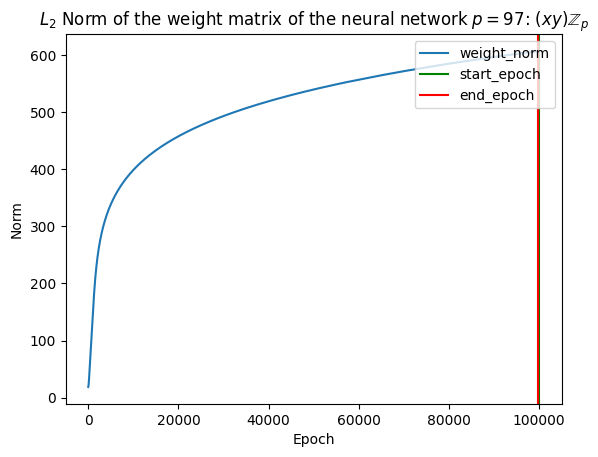

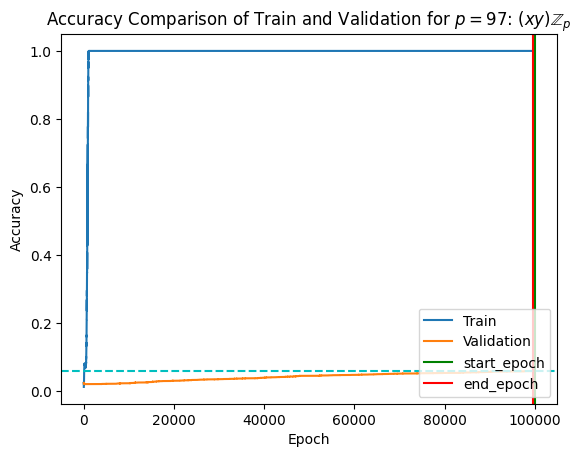

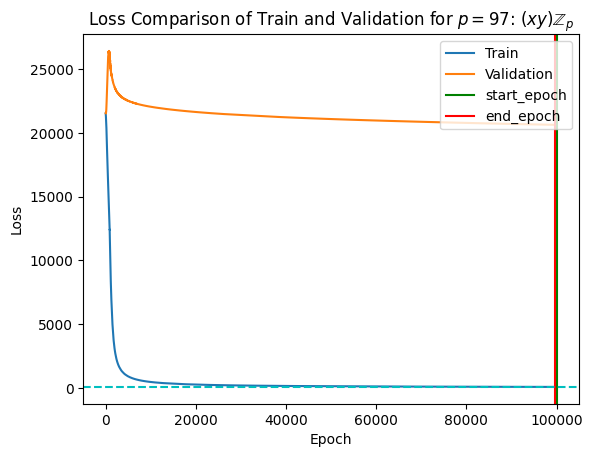

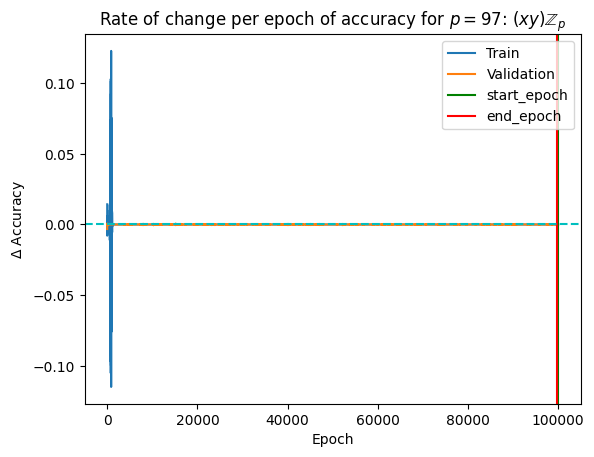

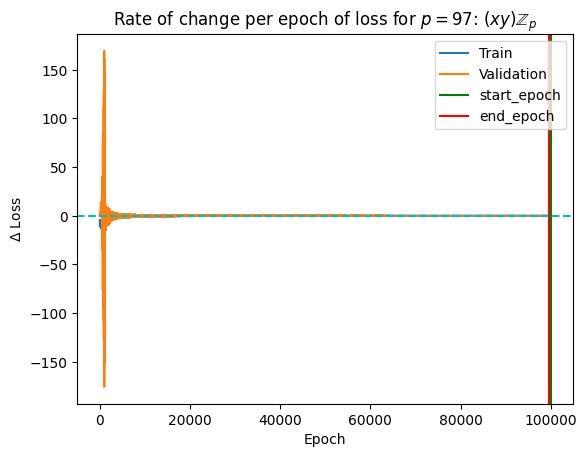

Assuming 100% train accuracy for  x*y mod97
These samples were not learnt
[(14, 42), (20, 89), (90, 9), (46, 15), (88, 11), (93, 54), (60, 29), (29, 23), (65, 96), (38, 29), (93, 18), (75, 50), (69, 72), (38, 88), (18, 39), (49, 66), (96, 59), (3, 69), (11, 11), (62, 84), (69, 35), (75, 78), (59, 91), (45, 63), (1, 34), (52, 4), (45, 7), (48, 29), (46, 48), (30, 45), (58, 88), (75, 67), (54, 69), (2, 71), (46, 21), (41, 26), (38, 22), (51, 23), (17, 77), (66, 64), (45, 64), (31, 53), (35, 39), (54, 40), (22, 79), (31, 71), (26, 81), (8, 13), (8, 6), (17, 79), (87, 9), (83, 27), (27, 32), (19, 85), (78, 56), (84, 52), (20, 82), (65, 81), (30, 38), (29, 93), (93, 62), (94, 57), (68, 5), (6, 41), (63, 3), (18, 94), (83, 23), (76, 78), (13, 16), (29, 49), (9, 59), (28, 43), (71, 71), (14, 15), (54, 6), (40, 68), (30, 63), (94, 81), (55, 72), (51, 56), (3, 76), (16, 26), (5, 58), (31, 61), (83, 63), (74, 71), (25, 53), (7, 54), (32, 42), (92, 91), (67, 84), (72, 27), (34, 72), (45, 56), (58

In [ ]:
model = None
prime = 97
operation = 'x*y'
epochs = 100_000
alpha = 0.5
hidden_dim = 500 # select approximately 5 * prime
model = MLP_Grok4(prime, hidden_dim)             # Model Prieto
threshold1 = 0.9
threshold2 = 1.0

run(prime, operation, epochs, alpha, threshold1, threshold2, hidden_dim = hidden_dim)

update = extract_hard_to_learn(operation, prime)
print('These samples were not learnt')
print(update)

fr, fc = get_data_distribution(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution(tups, outs, prime = prime)

print("Metric for learning difficulty (Old)", KL_divergence(fr, fc, fr1, fc1))

fr, fc = get_data_distribution_proj(train_inputs, train_outputs, prime = prime)
fr1, fc1 = get_data_distribution_proj(test_inputs, test_outputs, prime = prime)
fr2, fc2 = get_data_distribution_proj(tups, outs, prime = prime)

m1 = fill_in_matrix(train_inputs, train_outputs)
m2 = fill_in_matrix(test_inputs, test_outputs)
m3 = fill_in_matrix(tups, outs)
m4 = update_matrix(update, m3)

plt.matshow(m1)
plt.title("Visual of Train Table")
plt.show()

plt.matshow(m2)
plt.title("Visual of Test Table")
plt.show()

plt.matshow(m3)
plt.title("Visual of Full Table")
plt.show()

plt.matshow(m4)
plt.title("Visual of Predicted Table")
plt.show()

print("Metric for learning difficulty (New)", new_metric(fr, fc, fr1, fc1, fr2, fc2))

# Notes

1. So far, my metrics have not shown substantial correlation to grokking difficulty. Also, I can see from the plots that it might be better to consider some sort of measure of symmetry of the tables as against randomness of the tables to get this metric. I will work on that.
2. I have also observed that the sweet spot for the size of the table to experiment with for Grokking is $67 \times 67$ (although needing about $5$ times number of epochs for $97 \times 97$). This suggests that the amount of data is a critical factor of grokking. I shall study this "edge" case more to craft my metric.
3. I have observed that ReLU activation gives the best performance, but the networks should not be too wide (approximately $2.5$ times the first layer is good) to avoid slow learning. The new activation function at the output (projection on the $L_2$ unit ball) was a game changer. I might try other $L_p$ norm unit balls.
4. I have not played with soem hyper-parameters and so on like learning rate, loss function, weight decay, drop out. This is because of how computationally expensive the experiments are.
5. Multiplication for prime squares e.g. 121, behave like primes, while for very composite numbers, e.g. 72, grokking is more difficult
6. Constant mapping is learnt in 1 epoch, but random noise is only memorised so far.